# Caso 1 Econometría Financiera

## Análisis de SMA y EMA en una Acción Tecnológica del NASDAQ 500

Responsables:
- Diego Astaburuaga, 202010018-7
- Sebastián Flández, 

Acción escogida: MSTR

### Definición de SMA y EMA

La media móvil simple (SMA) es el promedio aritmético de los precios de cierre de un activo en un número determinado de períodos. Su ecuación se expresa como:


\begin{equation*}
SMA_t = \frac{1}{N} \sum_{i=0}^{N-1} P_{t-i},
\end{equation*}


donde $P_{t-i}$ representa el precio de cierre en el período $t-i$ y $N$ es la cantidad de períodos considerados.

Por otro lado, la media móvil exponencial (EMA) da mayor peso a los datos recientes, lo que la hace más reactiva a cambios en la tendencia del mercado. Se define como:

\begin{equation*}
EMA_t = \alpha P_t + (1 - \alpha) EMA_{t-1},
\end{equation*}
donde $\alpha$ es el coeficiente de suavizado, calculado como:
\begin{equation*}
\alpha = \frac{2}{N+1}.
\end{equation*}

### Periodos Clásicos y Señales de Trading

Los periodos más utilizados para las SMA y EMA son:

- Corto plazo: 10-20 días.
- Mediano plazo: 50 días.
- Largo plazo: 200 días.

Las señales de trading se generan cuando se cruzan las medias móviles. Algunas reglas clásicas incluyen:

- **Señal de compra**: cuando la SMA/EMA de corto plazo cruza al alza a la de largo plazo.
- **Señal de venta**: cuando la SMA/EMA de corto plazo cruza a la baja a la de largo plazo.


### Configuraciones a Evaluar


Para analizar el impacto de las SMA y EMA en la acción seleccionada, se probarán una serie de 4 configuraciones que se aplicarán tanto para SMA y EMA, tomando en cuenta los datos diarios del cierre del valor de las acciones en los últimos 2 años. Estas configuraciones corresponderán a:

1) Periodos de 12 y 26 días.
2) Periodos de 10 y 50 días.
3) Periodos de 20 y 200 días.
4) Periodos de 50 y 200 días.


In [1]:
#Librerias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

In [2]:
def MA_strat(input, fast_sma=30, slow_sma=60, strat="SMA", cost_ind=0.0000):
    """
    This function will allow you to create a simple moving average strategy
    input: str: The ticker you want to use
    fast_sma: int: The fast moving average
    slow_sma: int: The slow moving average
    strat: str: The strategy you want to use (SMA, EMA)
    """

    # Download the data
    df = yf.download(input, period='5y', interval='1d',  auto_adjust=True)
    
    # Create moving average
    if strat == "SMA":
        # Create Resistance using a rolling
        df["MA CP"] = df["Close"].rolling(fast_sma).mean()

        # Create Support using a rolling
        df["MA LP"] = df["Close"].rolling(slow_sma).mean() 
    elif strat == "EMA":
        # Create Resistance using a exponential moving average
        df["MA CP"] = df["Close"].ewm(span=fast_sma, adjust=False).mean()

        # Create Support using a exponential moving average
        df["MA LP"] = df["Close"].ewm(span=slow_sma, adjust=False).mean()

    # Start the strat on 2022
    df = df.loc['2022':]
    
    
    # Create the signals
    ## Create an empty columns to put the signals
    df["signal"] = np.nan
    ## Create the condition
    condition_buy = (df["MA CP"] > df["MA LP"]) & (df["MA CP"].shift(1) < df["MA LP"].shift(1))
    condition_sell = (df["MA CP"] < df["MA LP"]) & (df["MA CP"].shift(1) > df["MA LP"].shift(1))
    ## Put the signals
    df.loc[condition_buy, "signal"] = 1
    df.loc[condition_sell, "signal"] = -1
    

    # Plot the data with the signals
    plt.figure(figsize=(30, 12))
    ## Se posicionan las líneas de tendencia y las medias con labels
    plt.plot(df["Close"].index.to_numpy(), df["Close"].to_numpy(), label="Close Price")
    plt.plot(df["Close"].index.to_numpy(), df["MA CP"].to_numpy(), label=f"{strat} {fast_sma} días")
    plt.plot(df["Close"].index.to_numpy(), df["MA LP"].to_numpy(), label=f"{strat} {slow_sma} días")
    ## Se posicionan los puntos en el gráfico con labels
    index_buy = df.loc[df['signal'] == 1].index
    index_sell = df.loc[df['signal'] == -1].index
    plt.scatter(index_buy, df.loc[index_buy]["Close"], color="yellow", marker="^", label="Buy Signal", zorder = 2, s=100)
    plt.scatter(index_sell, df.loc[index_sell]["Close"], color="red", marker="v", label="Sell Signal", zorder = 2, s=100)
    ## zorder es para que los puntos aparezcan al frente
    ## Mostrar la leyenda
    plt.legend(loc='upper left', fontsize=25)
    plt.title(f'{strat}({fast_sma}) y {strat}({slow_sma})', fontsize=30)
    plt.xlabel("Periodos", fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylabel("Dólares USD$", fontsize=20)
    plt.yticks(fontsize=15)
    ## Mostrar gráfico
    plt.show()
    
    # Calculate the returns
    ## We say signal when we open or close a trade and poistion to talk about the whole time we are into a trade
    df["position"] = df["signal"].ffill().fillna(value=0)
    ## We create a vector of cost
    df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0)
    ## Compute the percentage of variation of the asset
    df["pct"] = df["Close"].pct_change(1)
    ## Compute the cumulative percentage of variation
    df["cpct"] = (1 + df["pct"]).cumprod()
    ## Compute the return of the strategy
    df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])
    ## Compute the cumulative return
    df["creturns"] = (1 + df["return"]).cumprod()
    ## Plot the returns
    plt.figure(figsize=(30, 12))
    plt.plot(df["cpct"], label="Returns")
    plt.plot(df["creturns"], label="Strategy")
    plt.legend(loc='upper left', fontsize=25)
    plt.title(f'{strat}({fast_sma}) y {strat}({slow_sma})', fontsize=30)
    plt.xlabel("Periodos", fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylabel("%Dólares USD$", fontsize=20)
    plt.yticks(fontsize=15)
    plt.show()
    
    return df

[*********************100%***********************]  1 of 1 completed


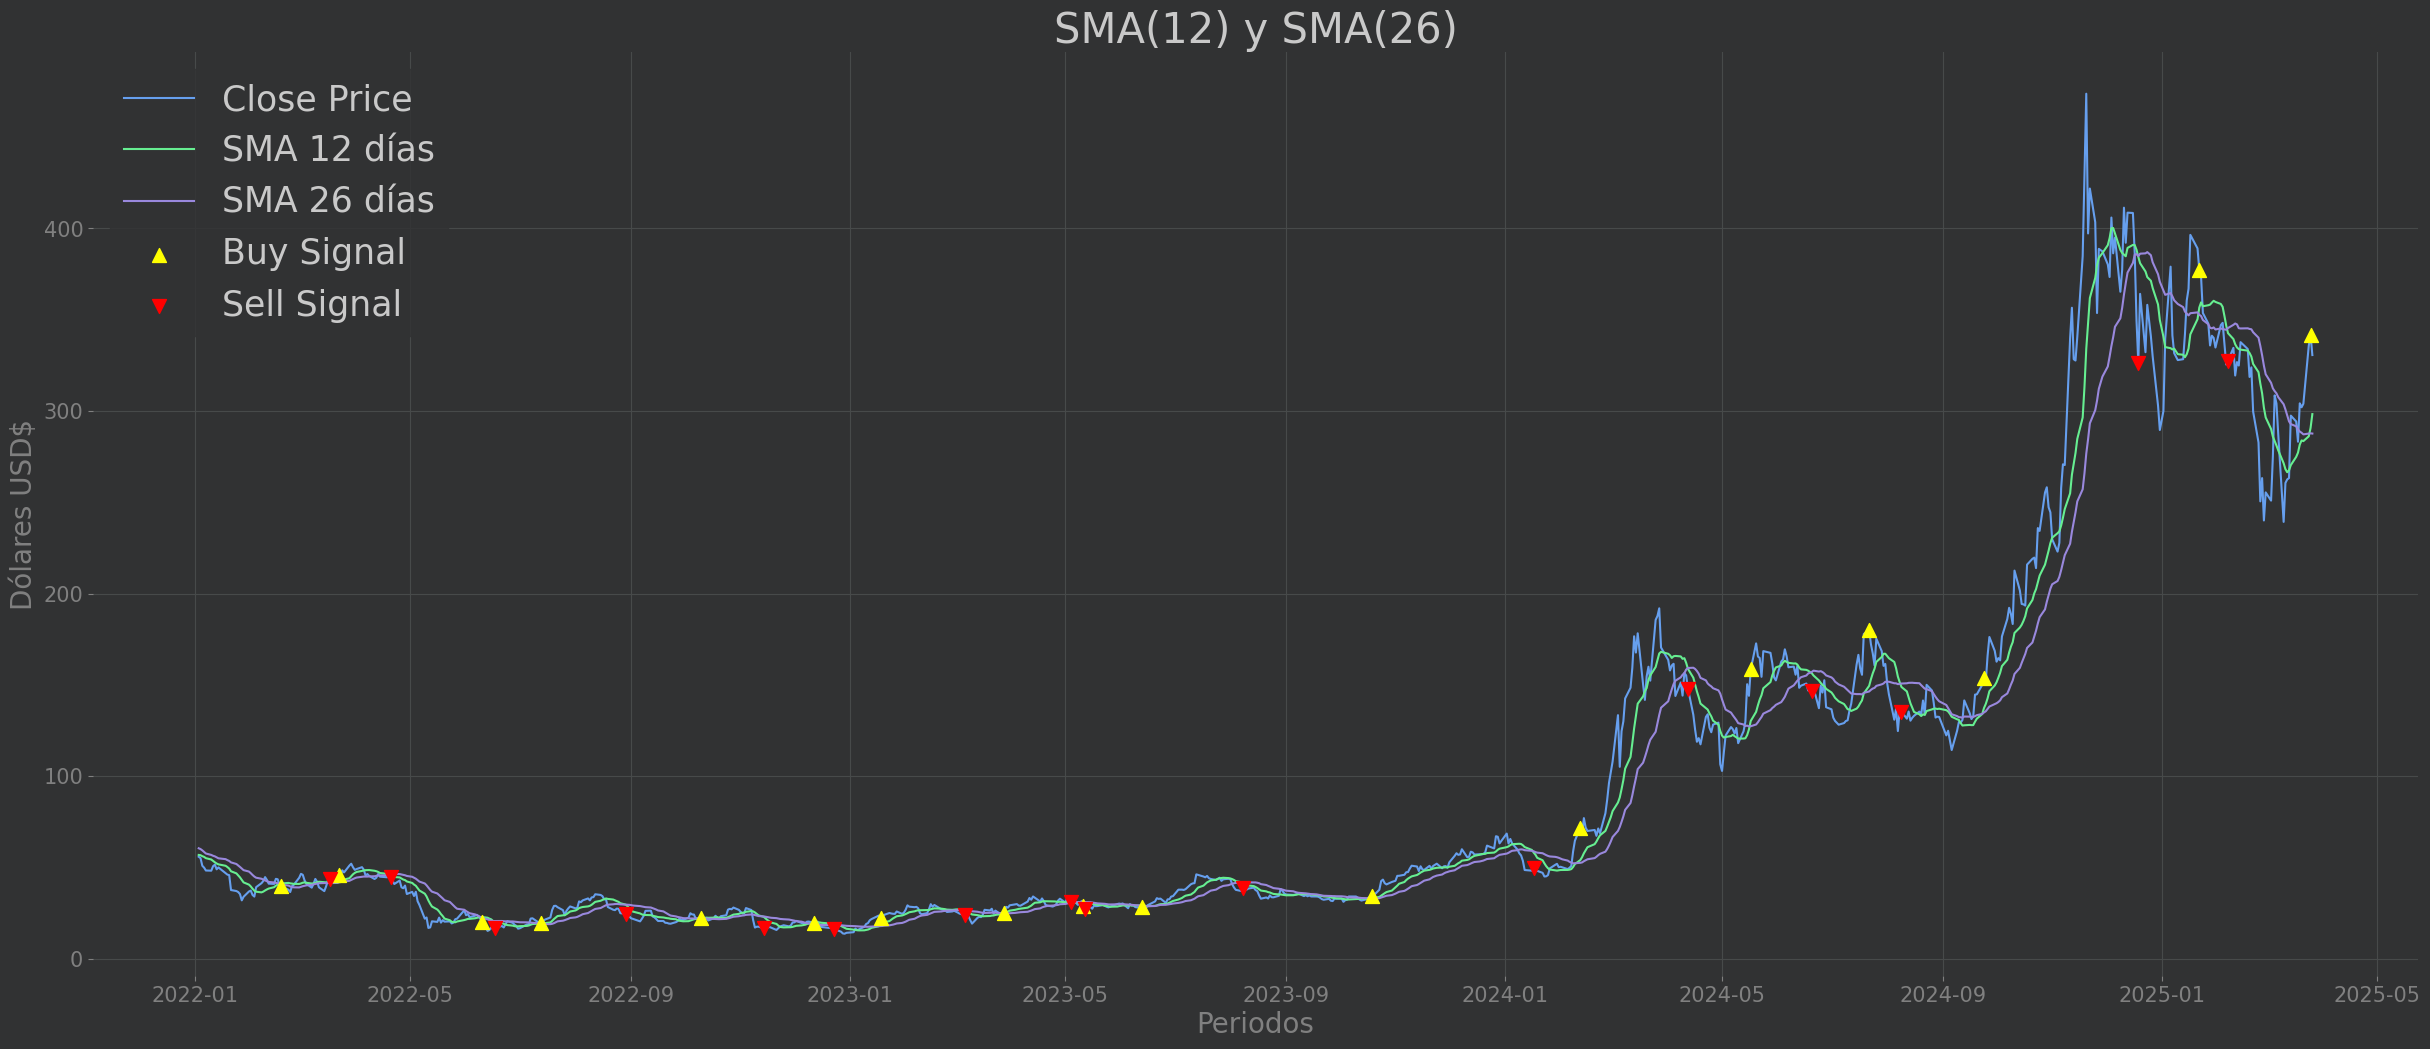

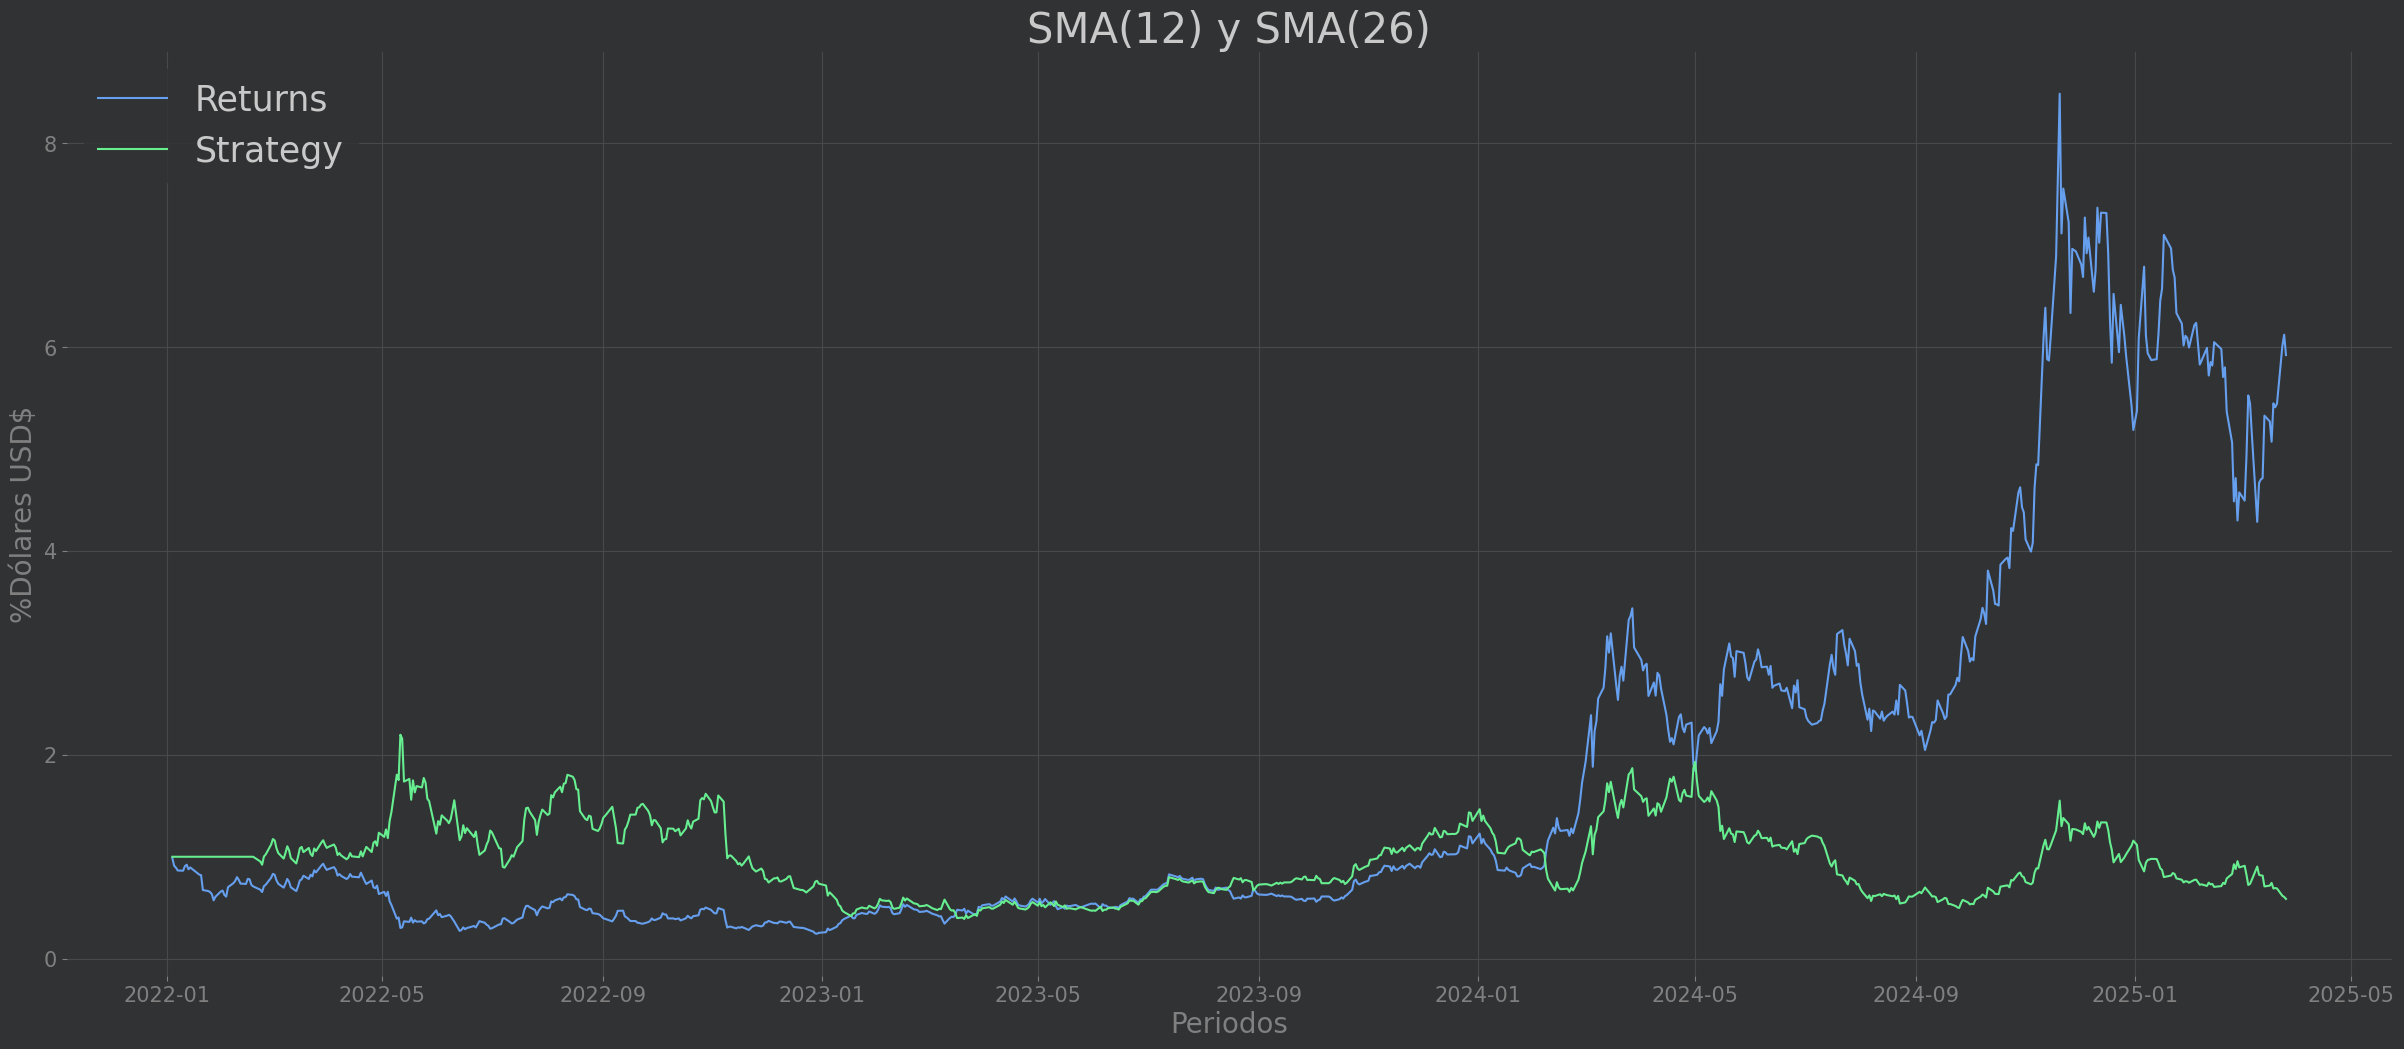

[*********************100%***********************]  1 of 1 completed


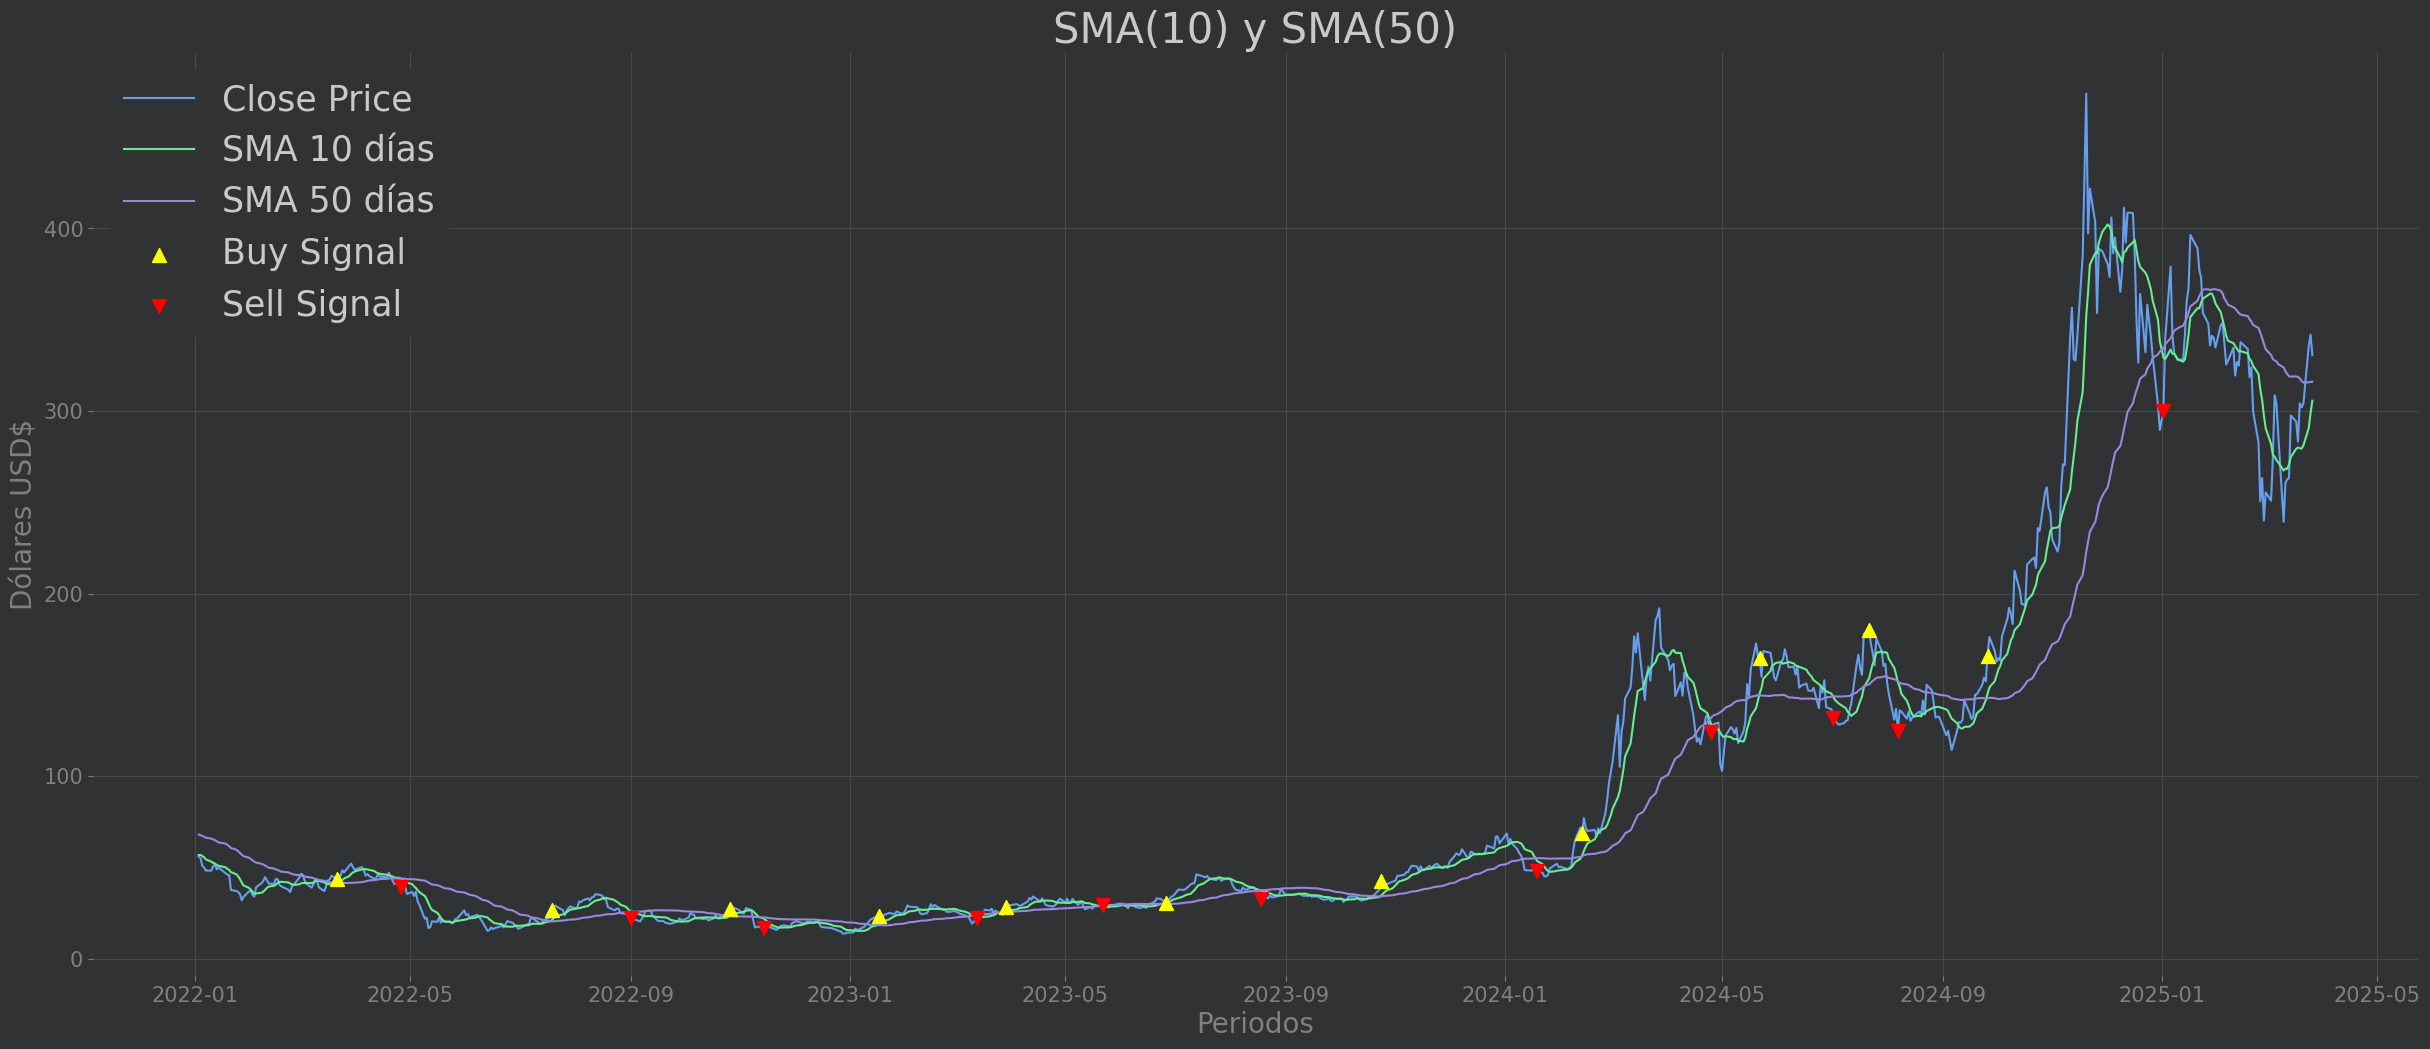

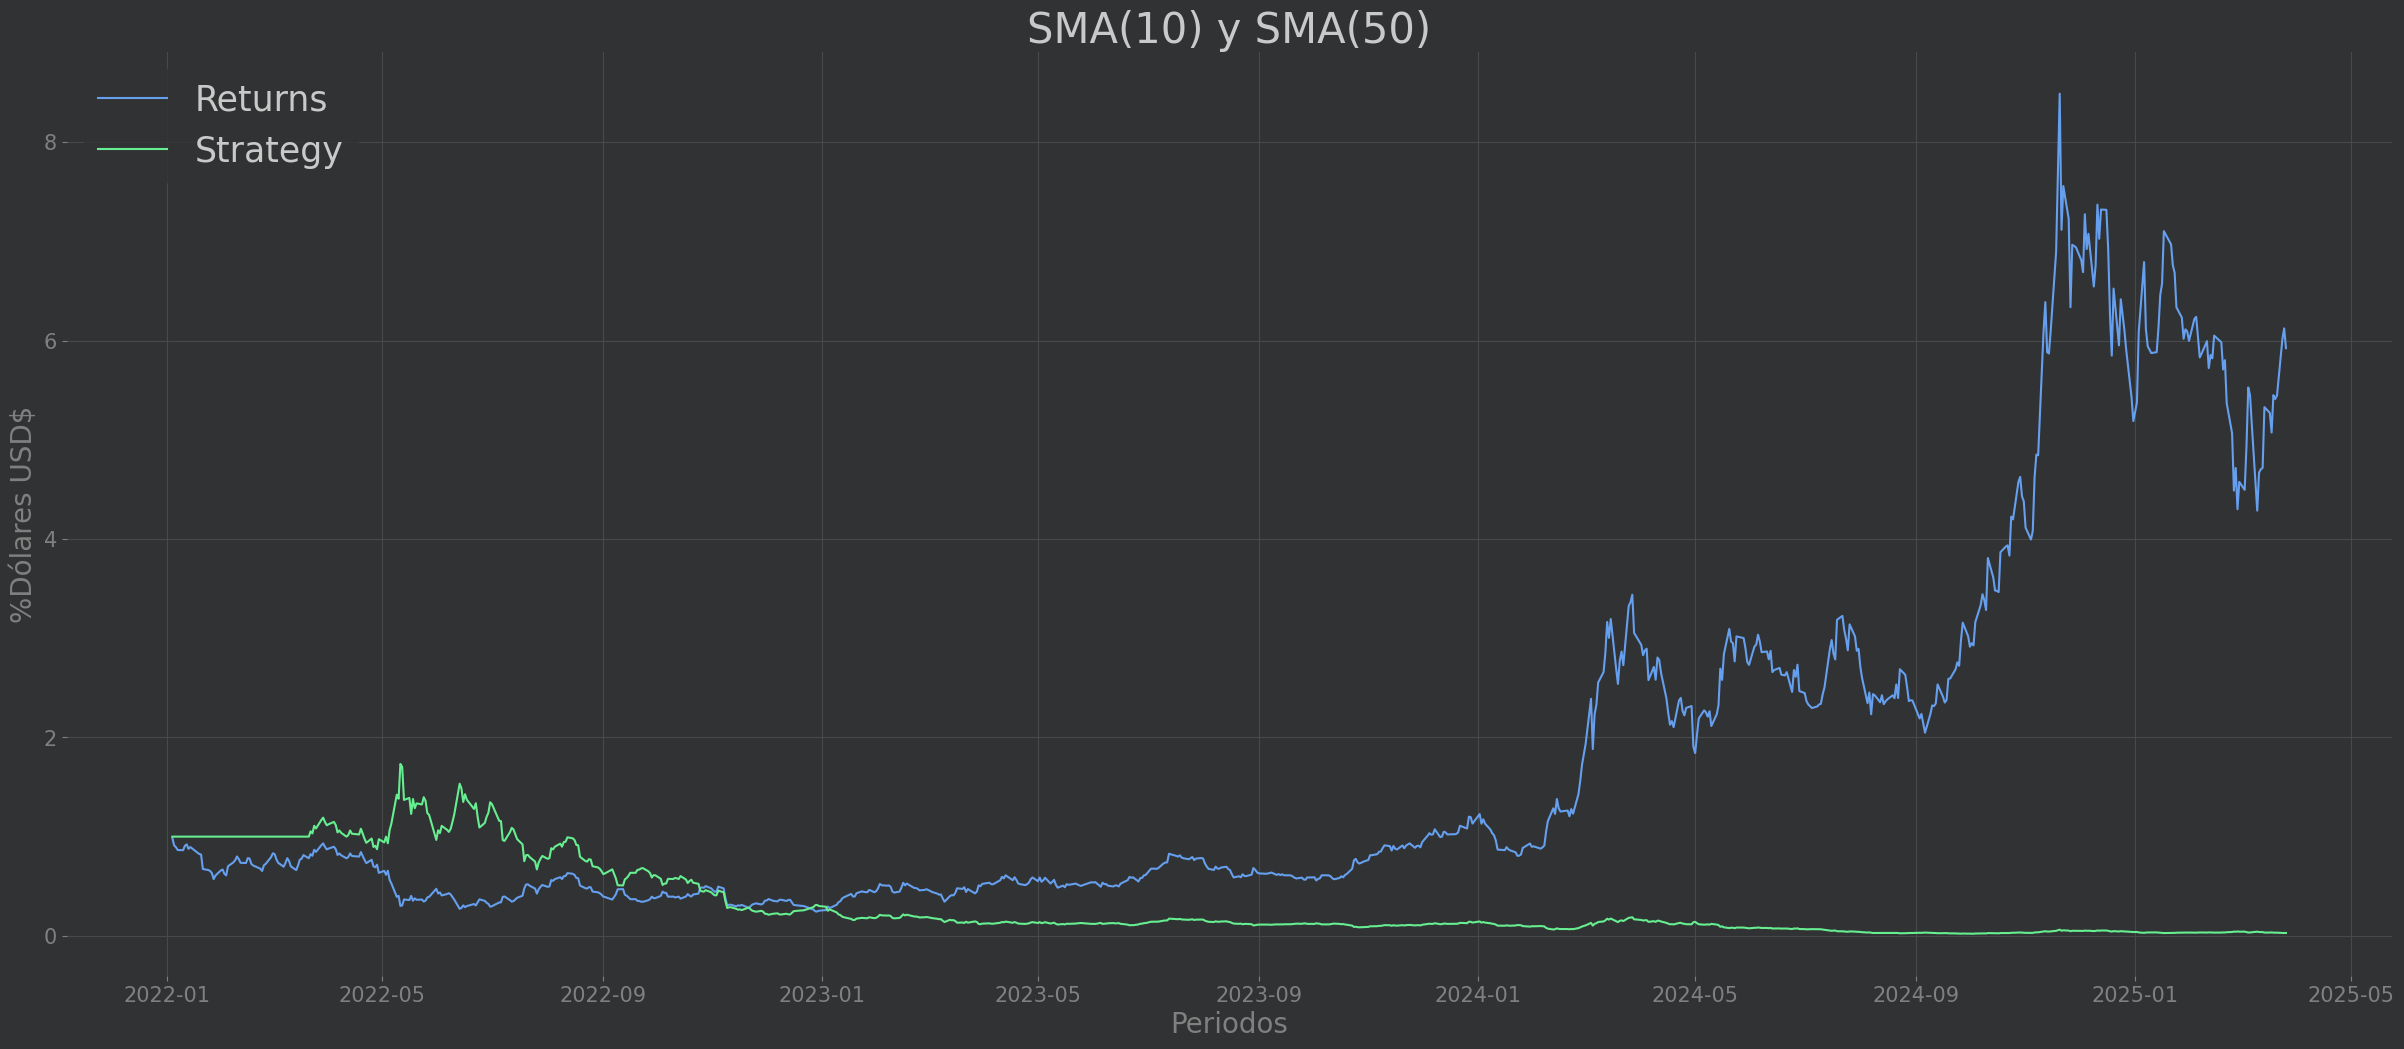

[*********************100%***********************]  1 of 1 completed


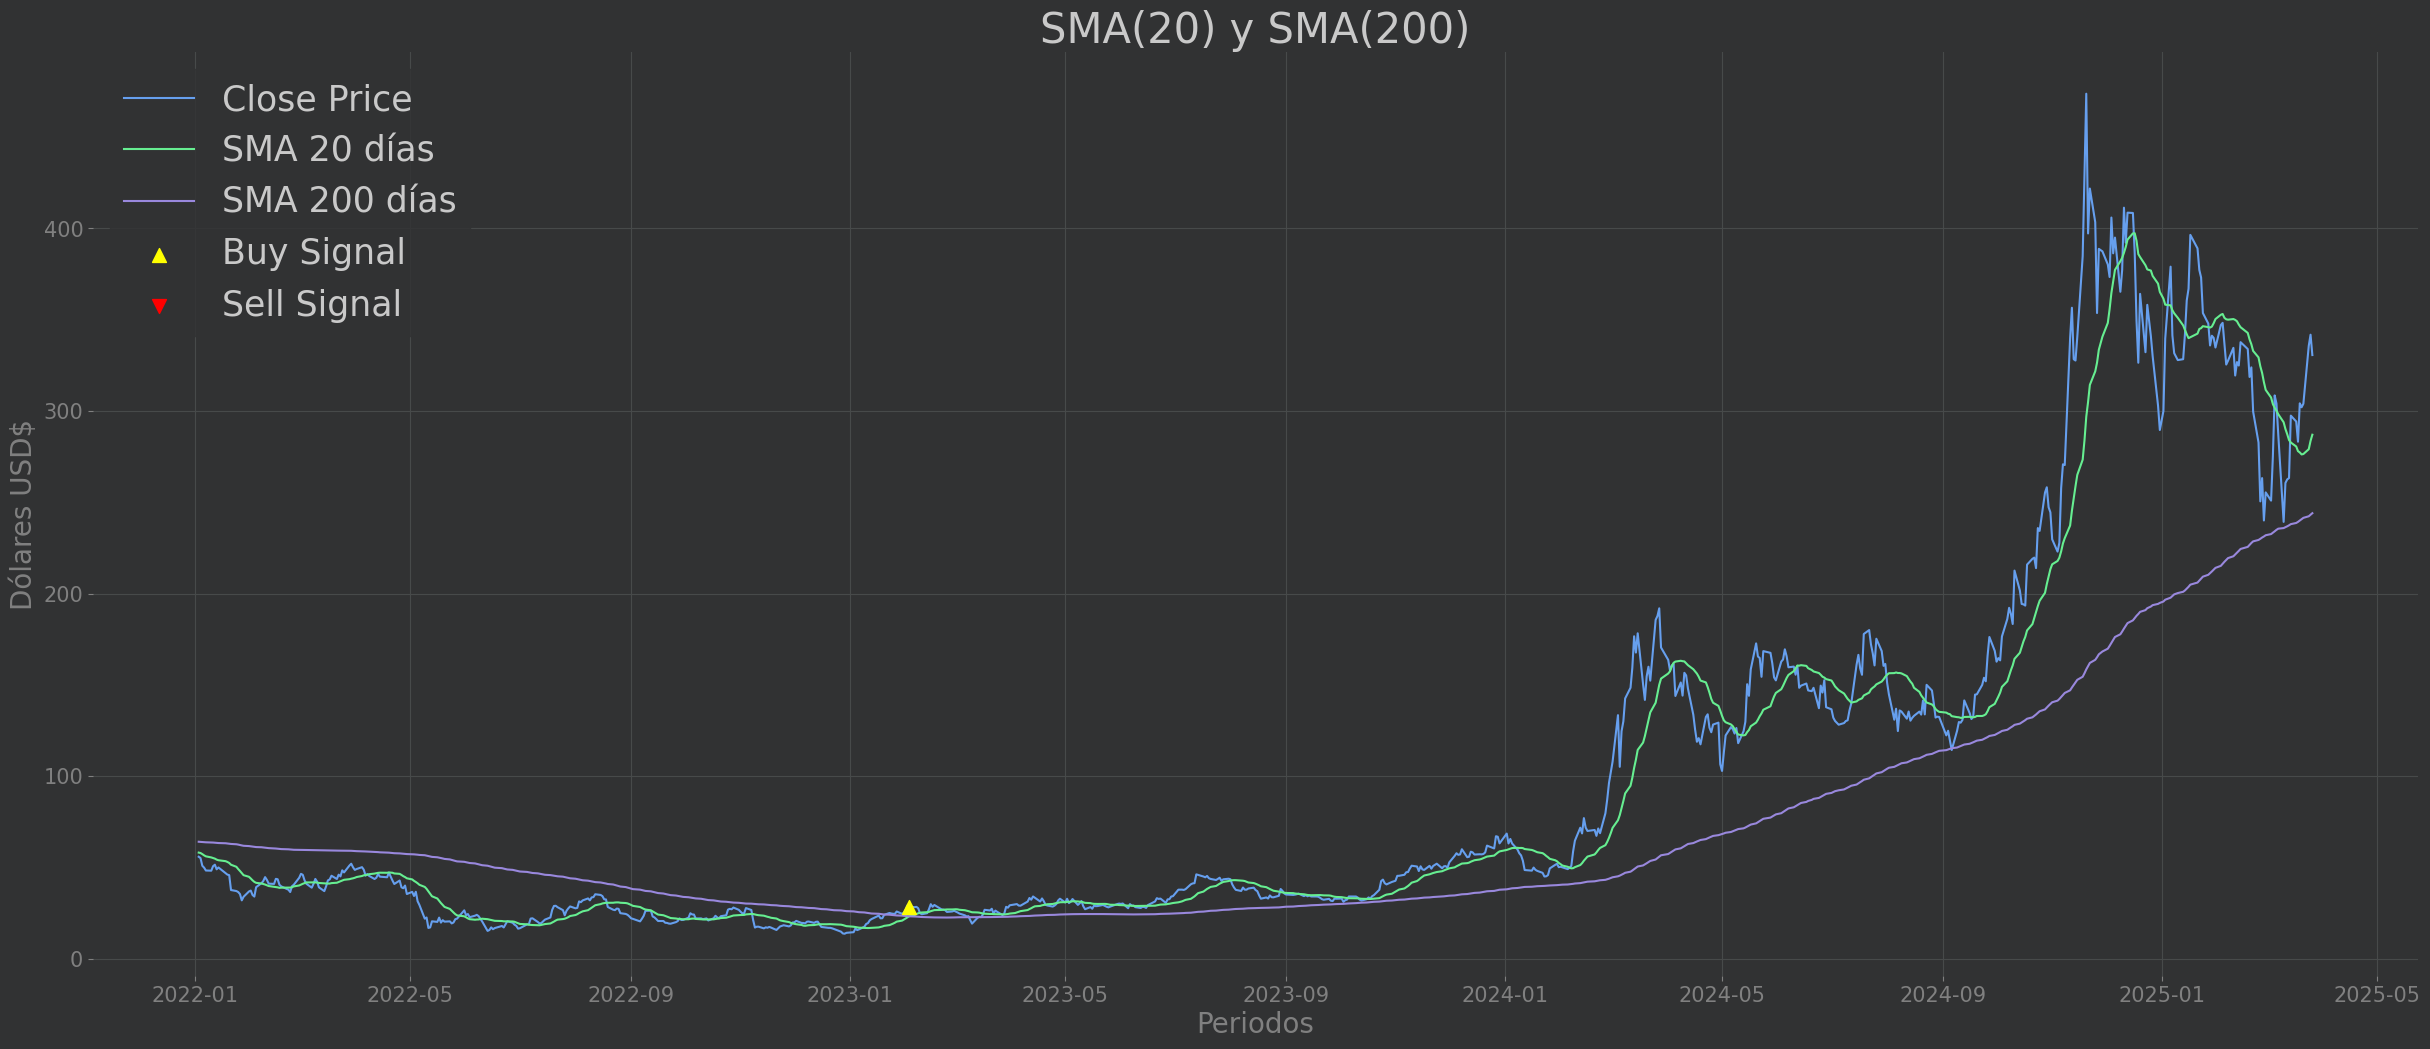

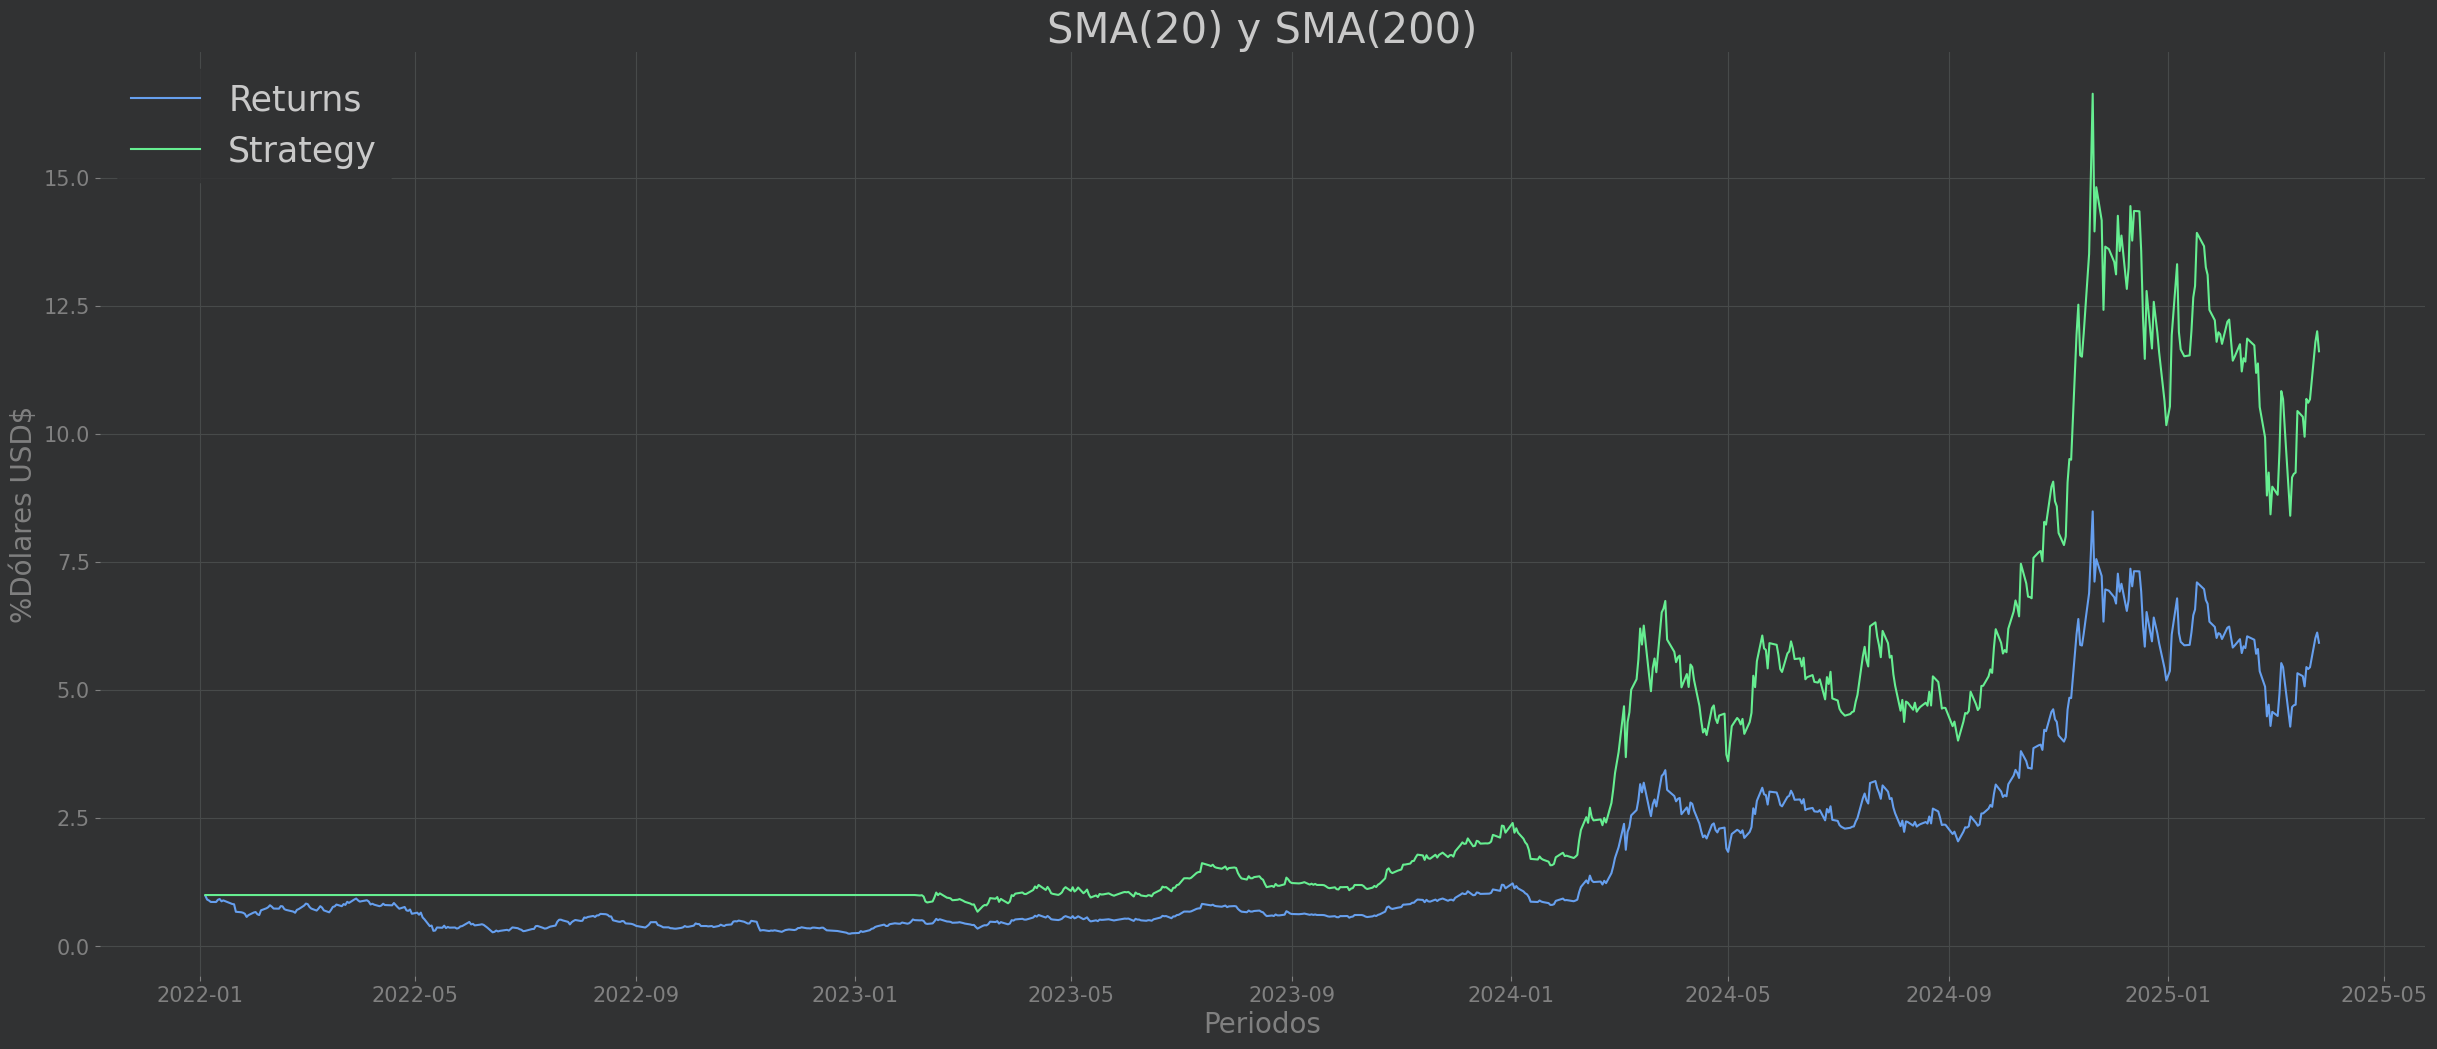

[*********************100%***********************]  1 of 1 completed


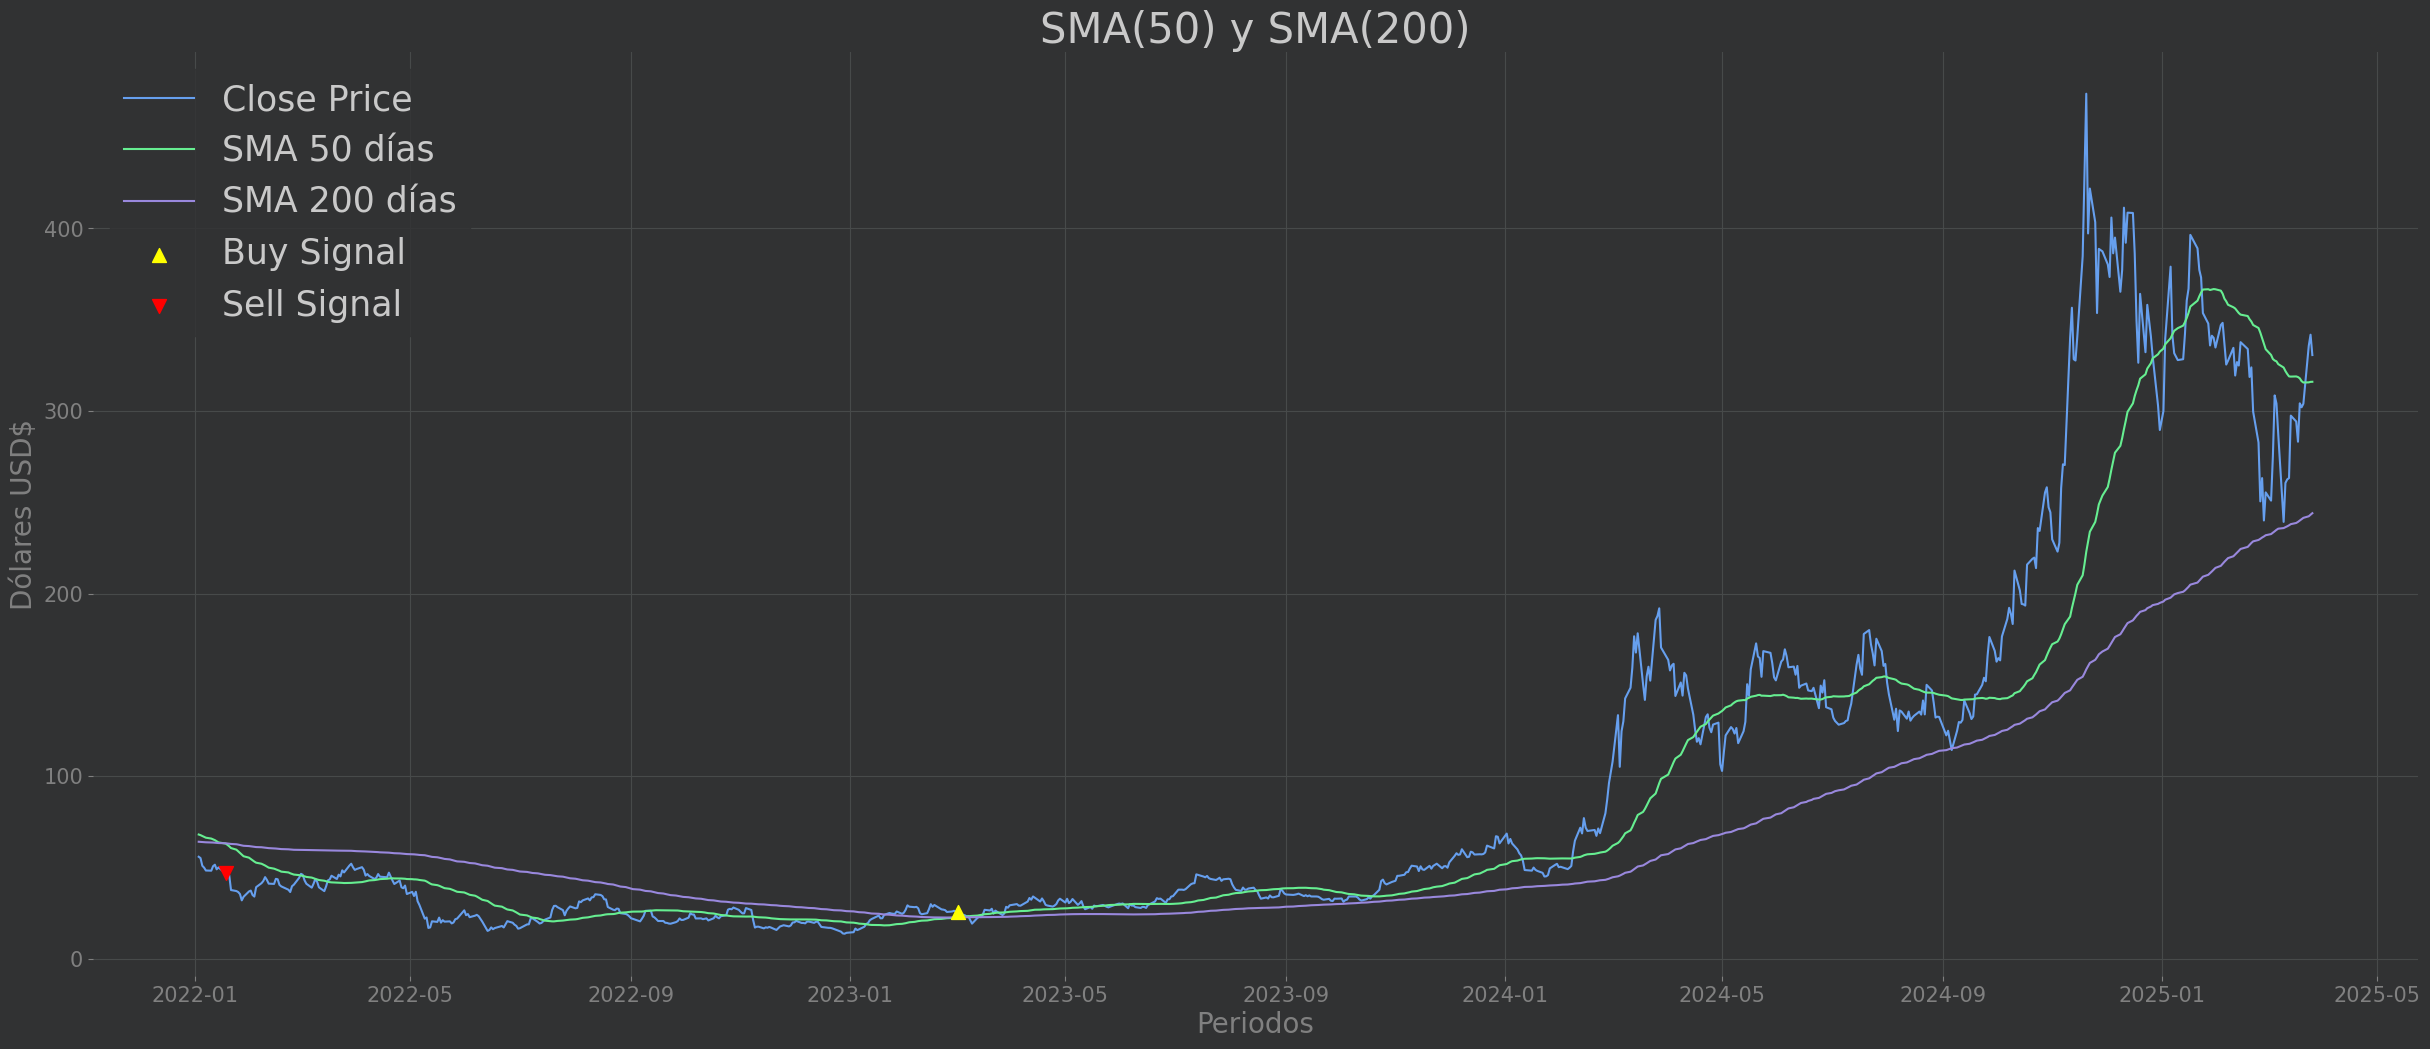

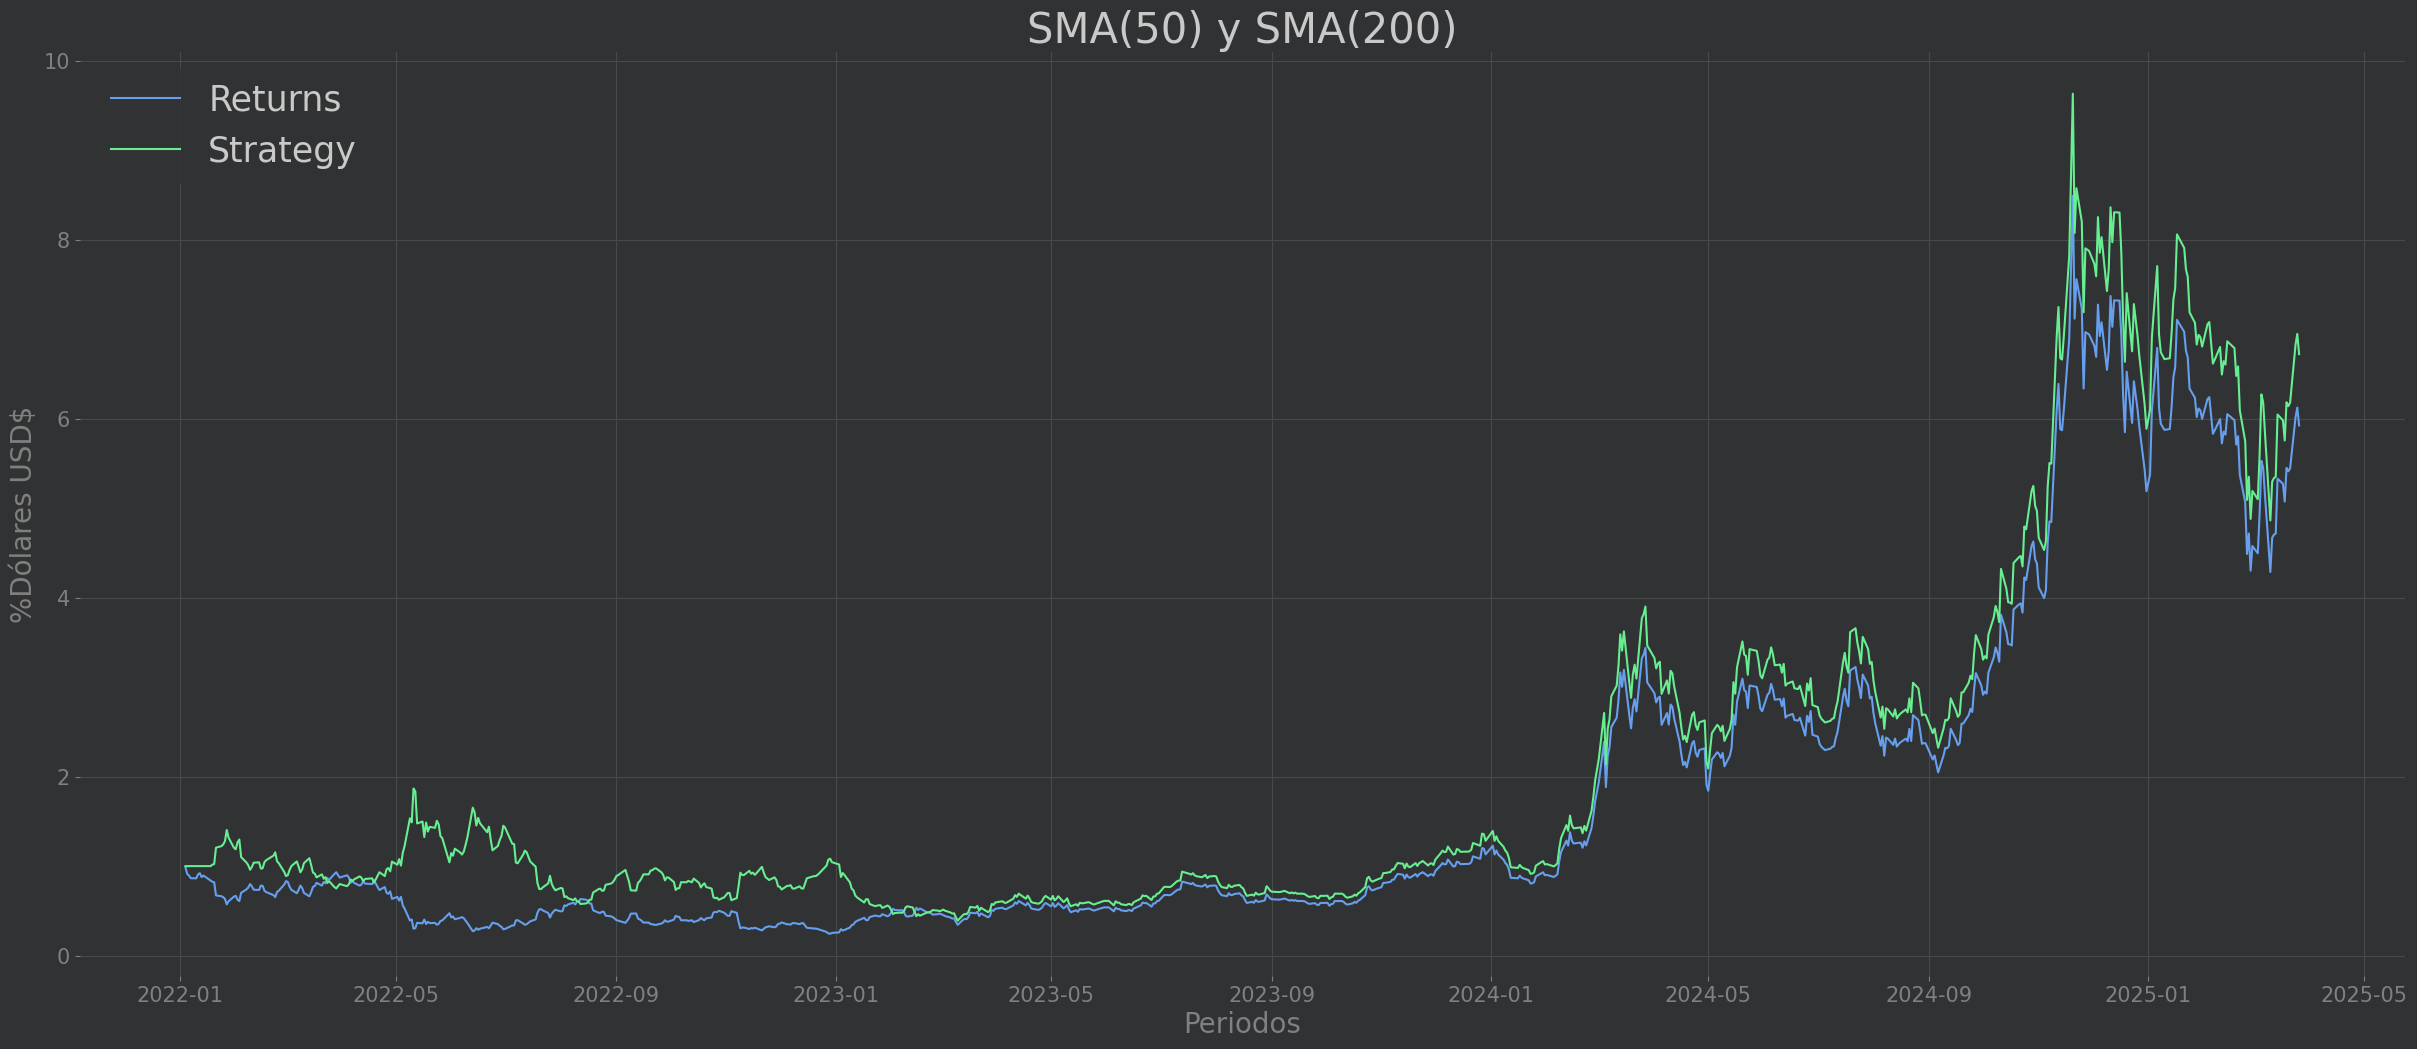

[*********************100%***********************]  1 of 1 completed


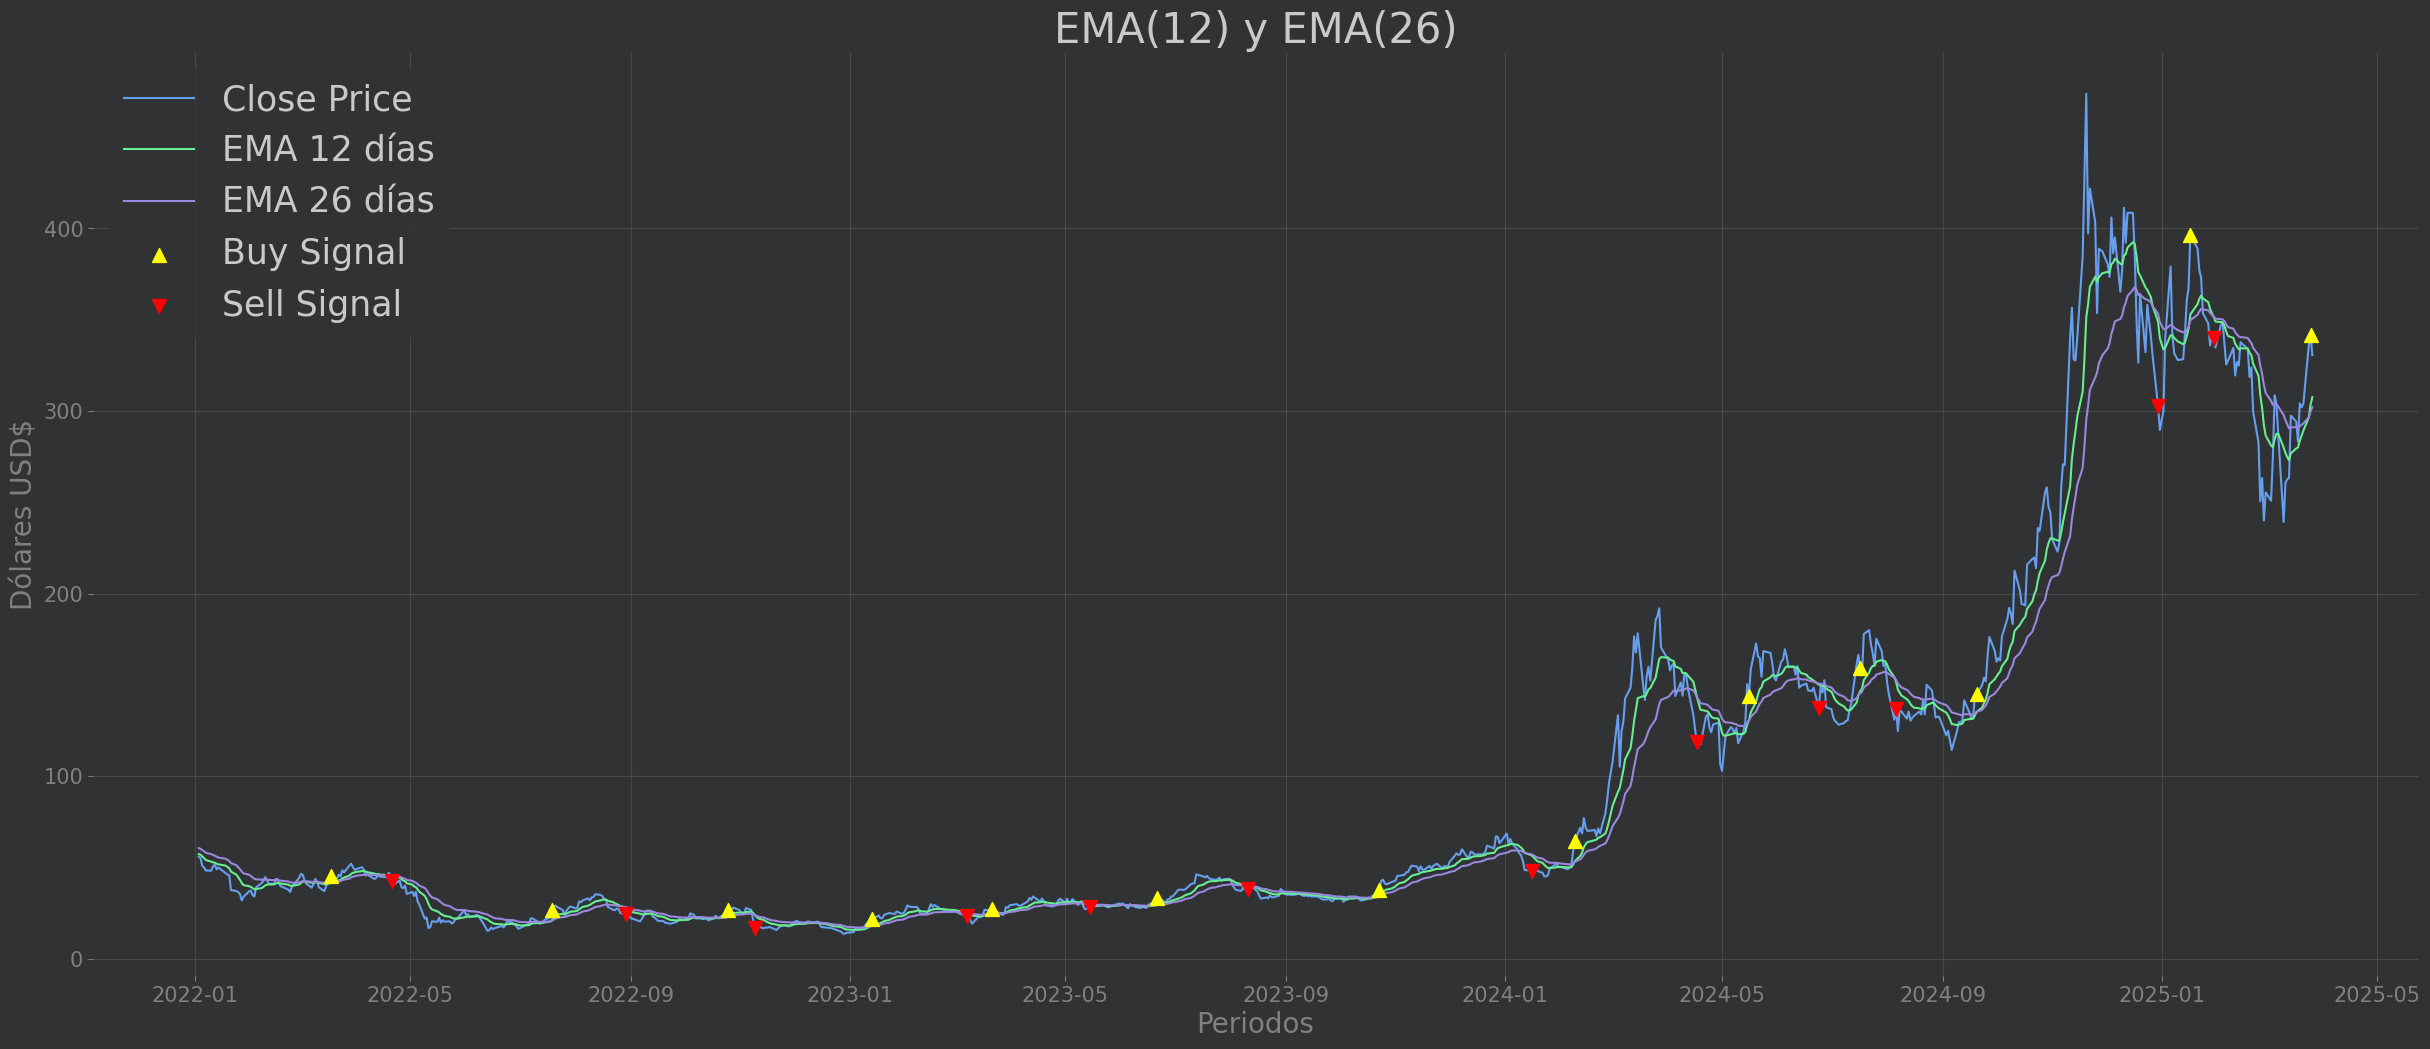

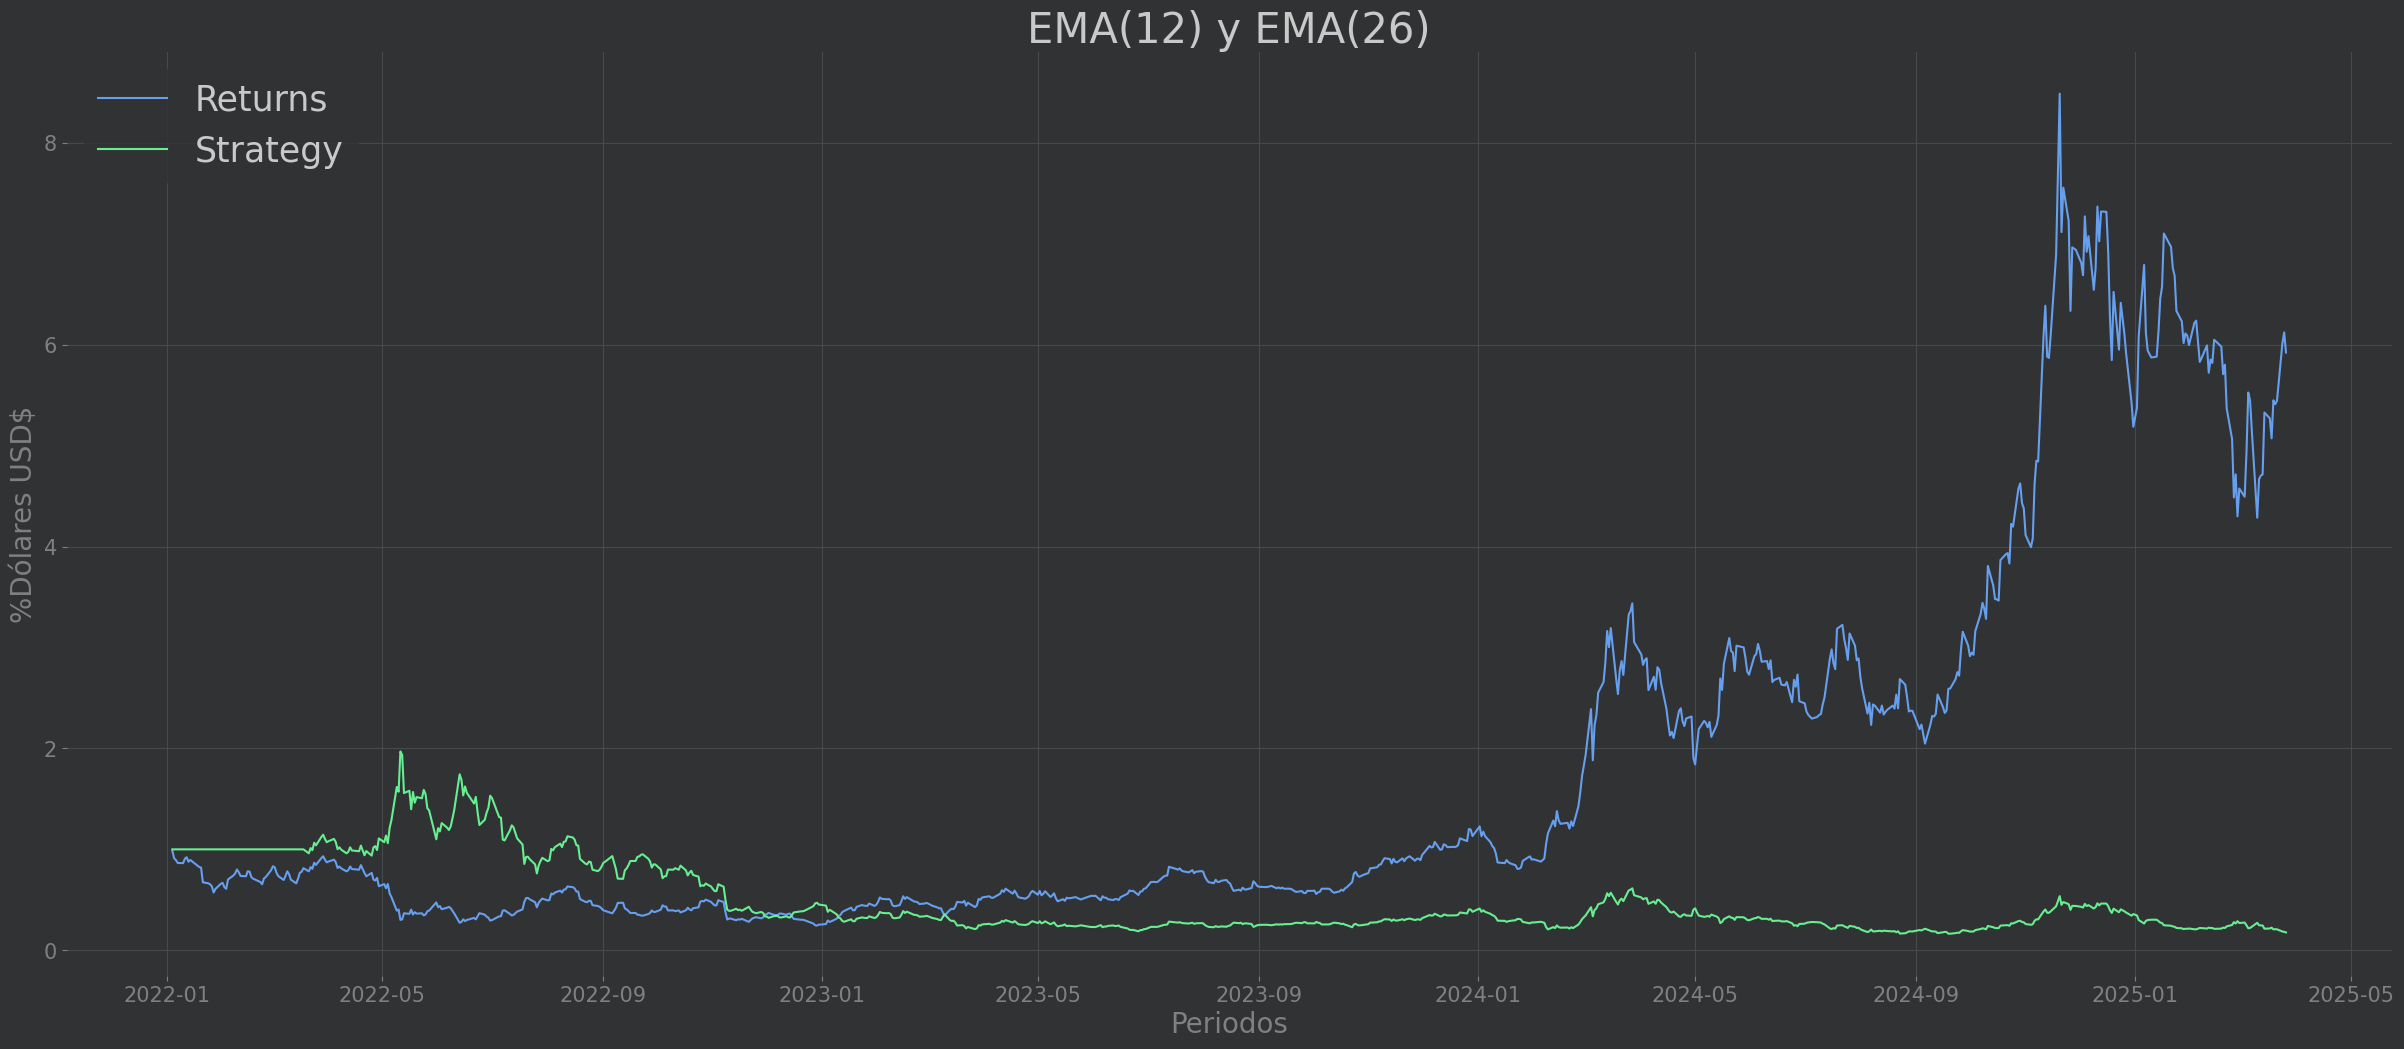

[*********************100%***********************]  1 of 1 completed


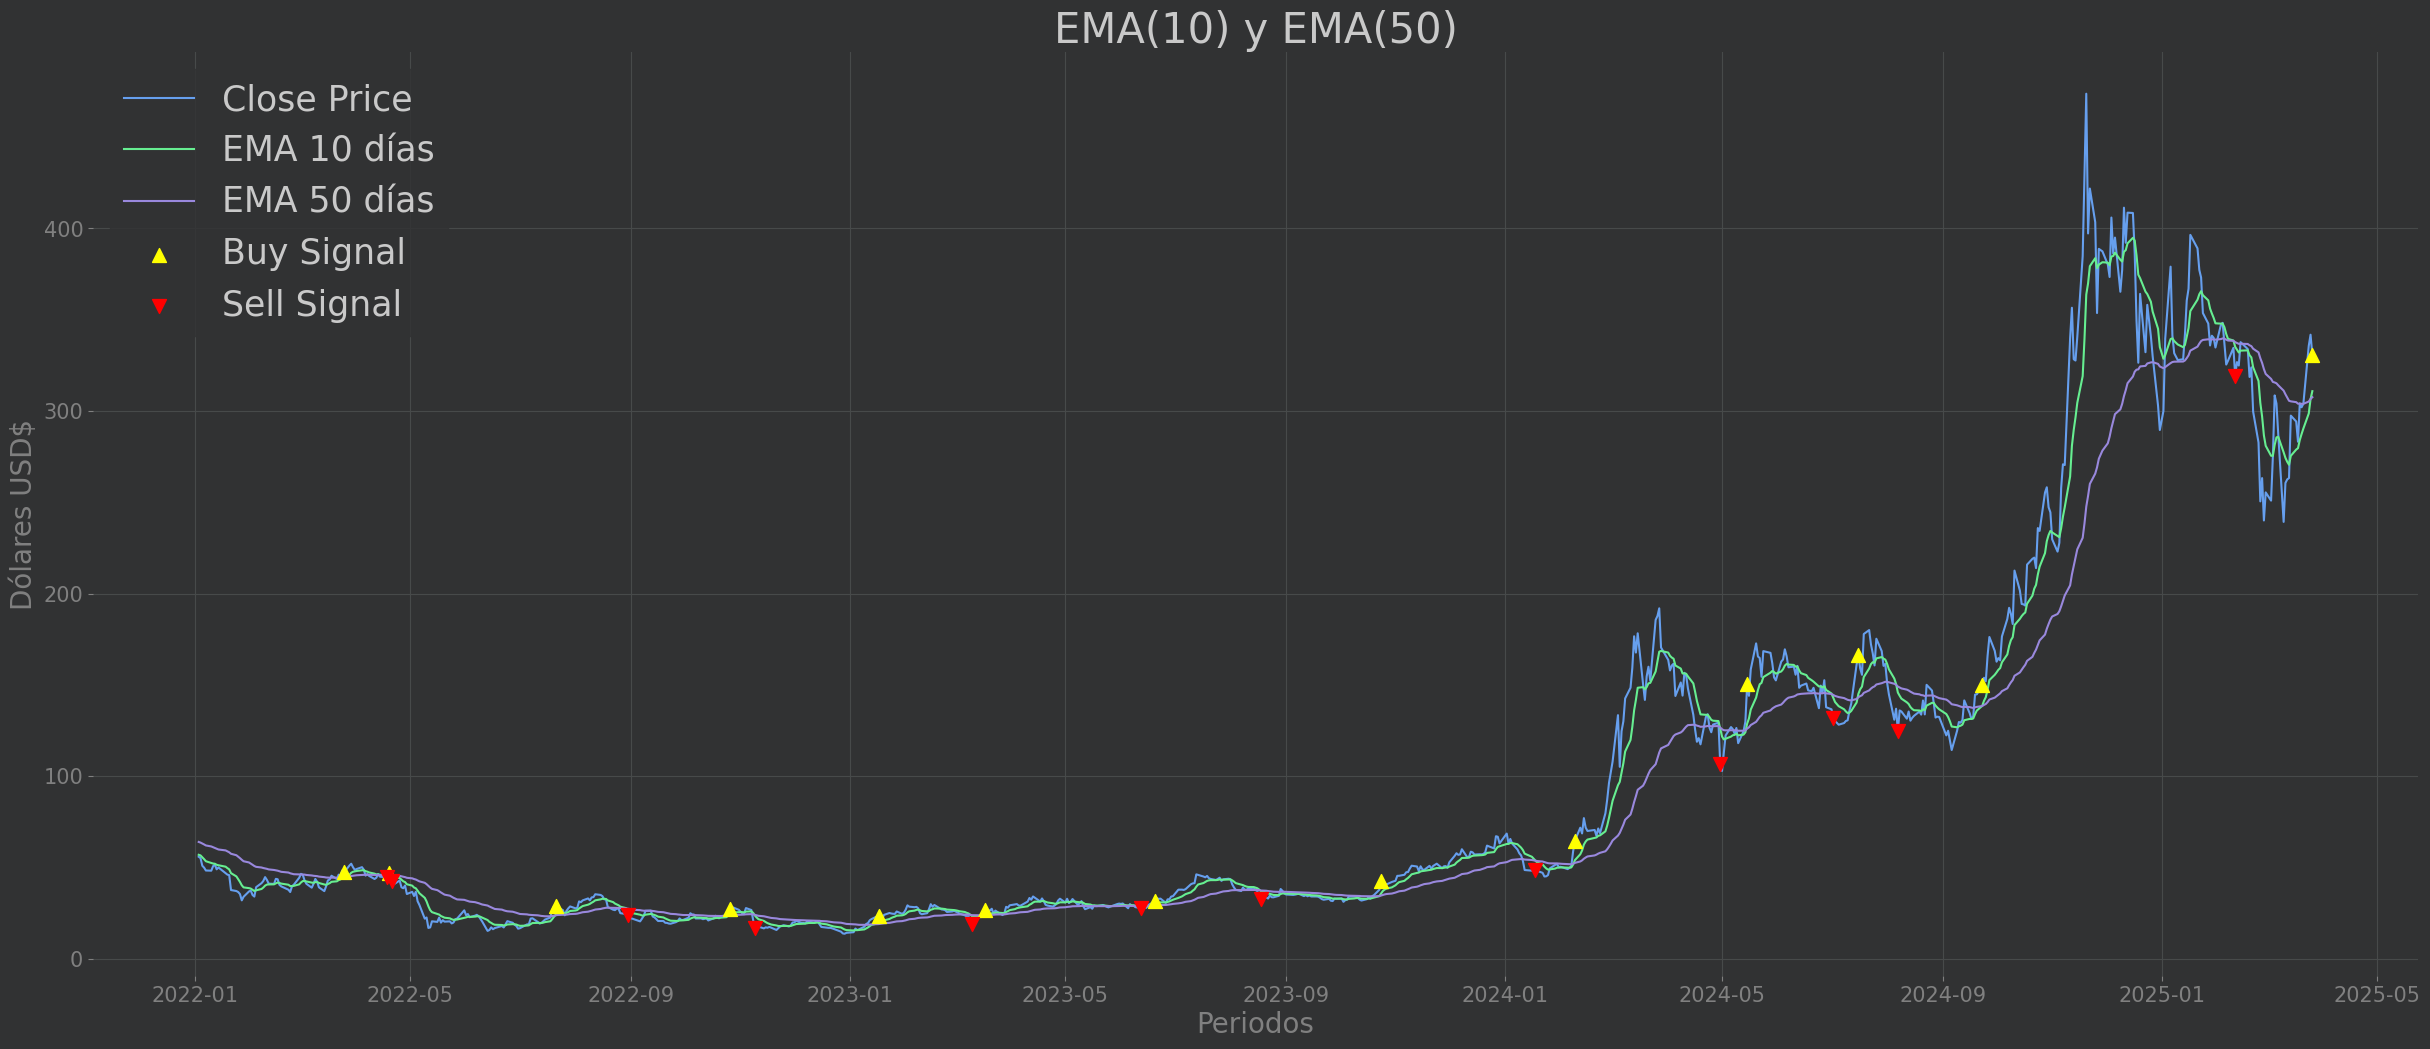

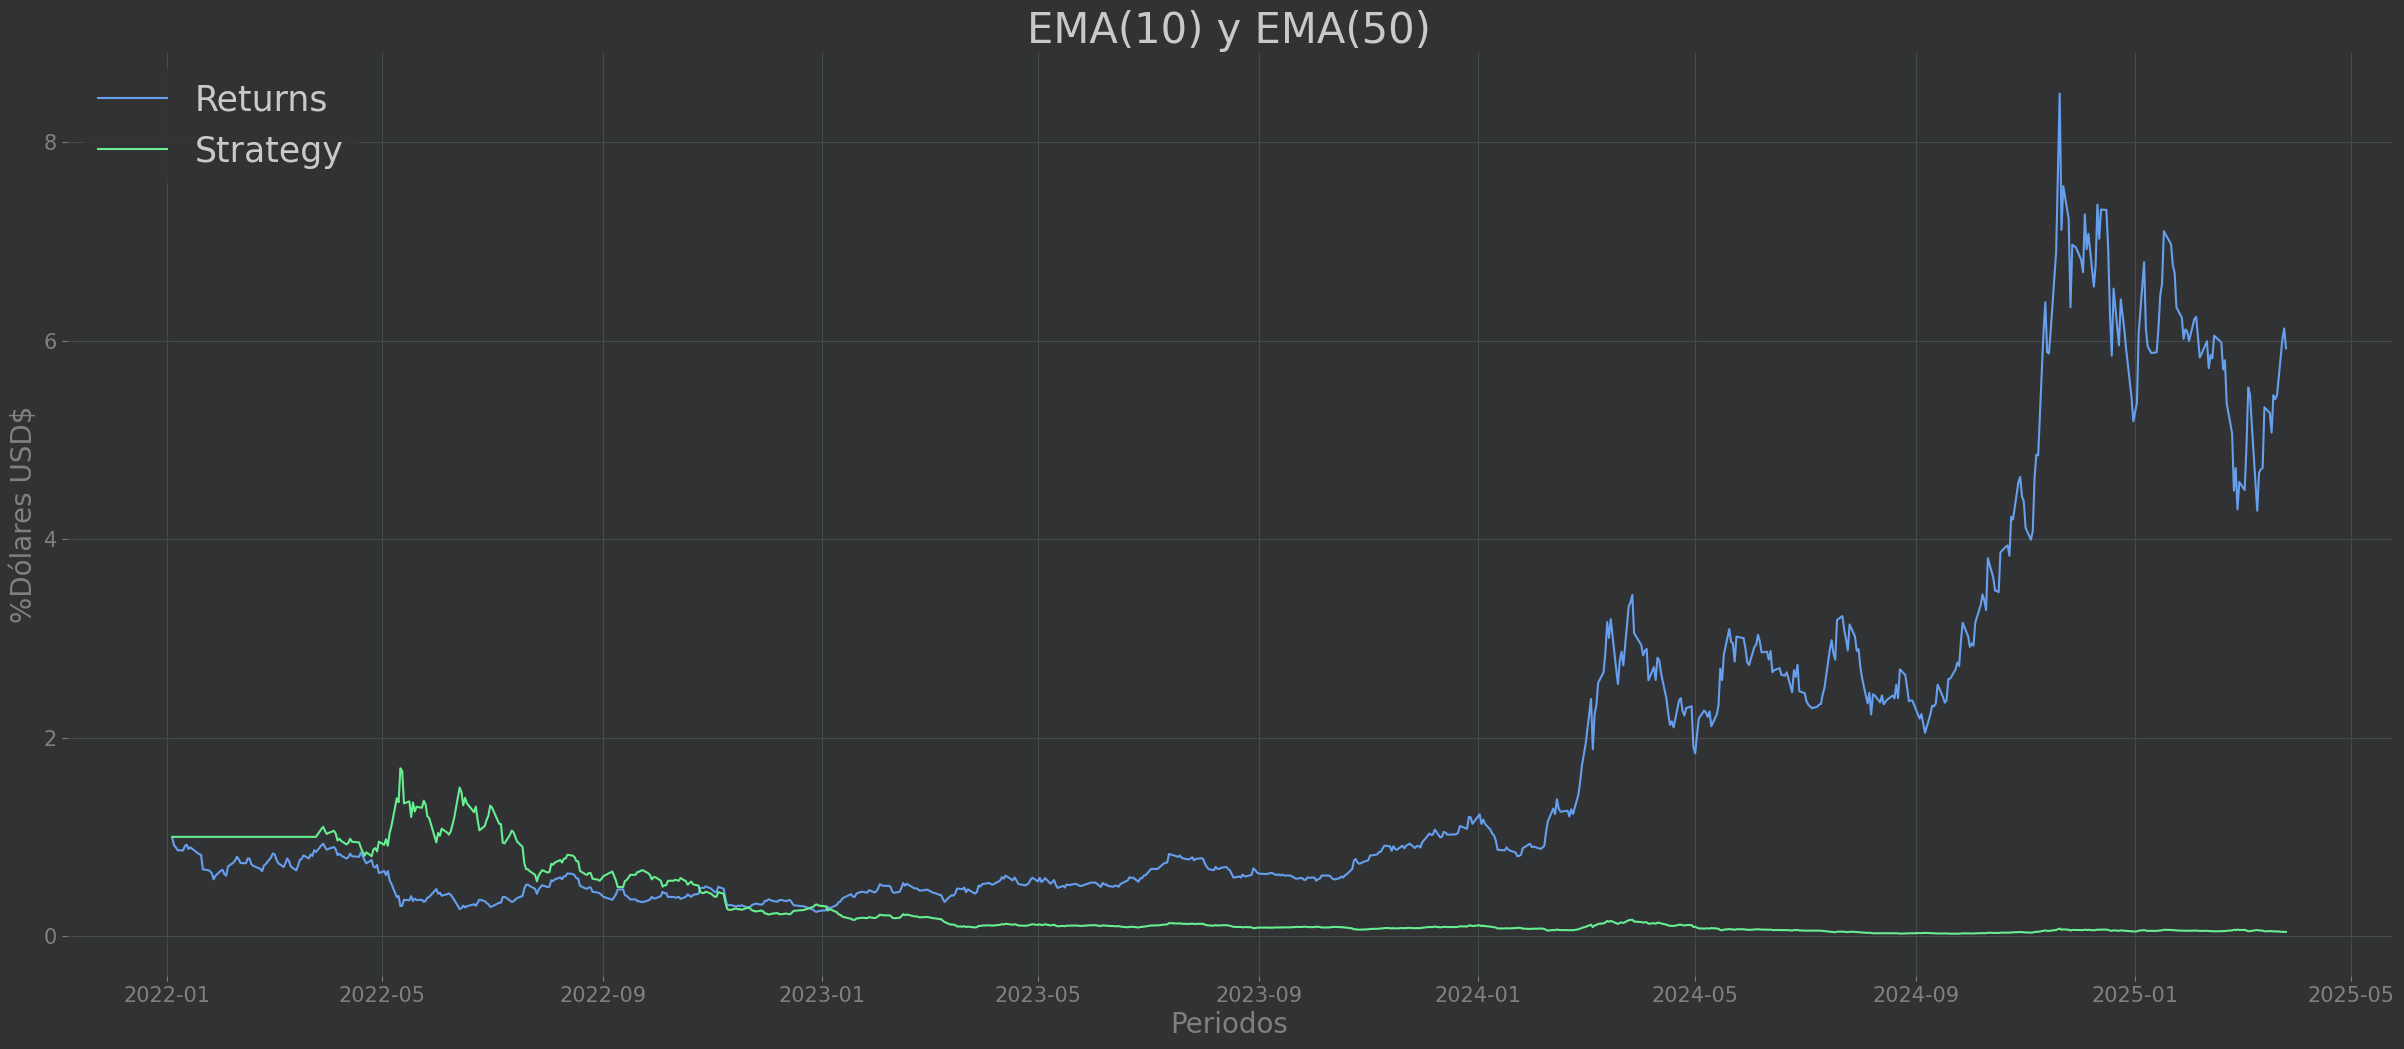

[*********************100%***********************]  1 of 1 completed


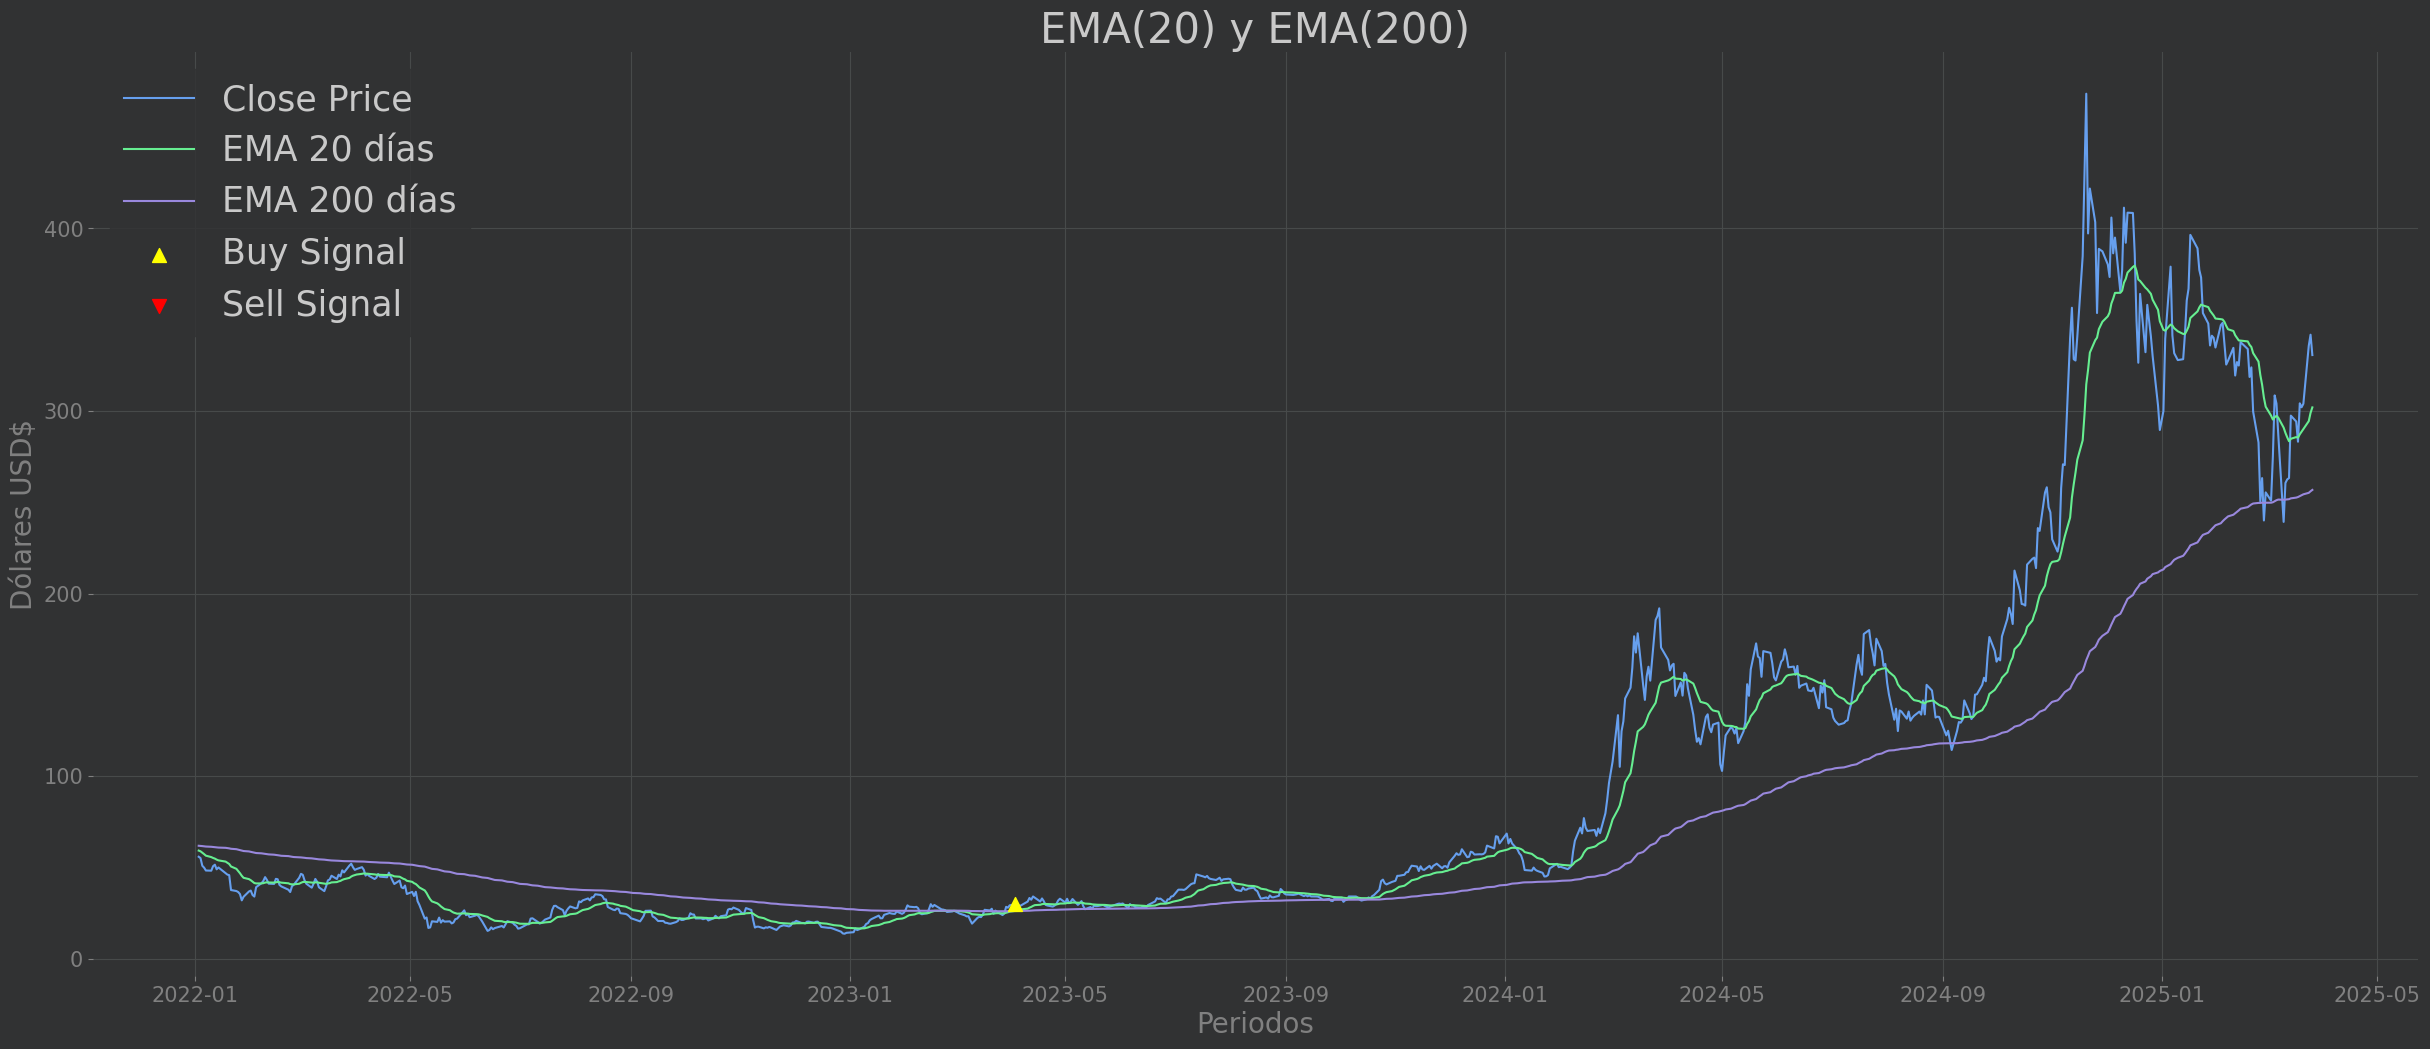

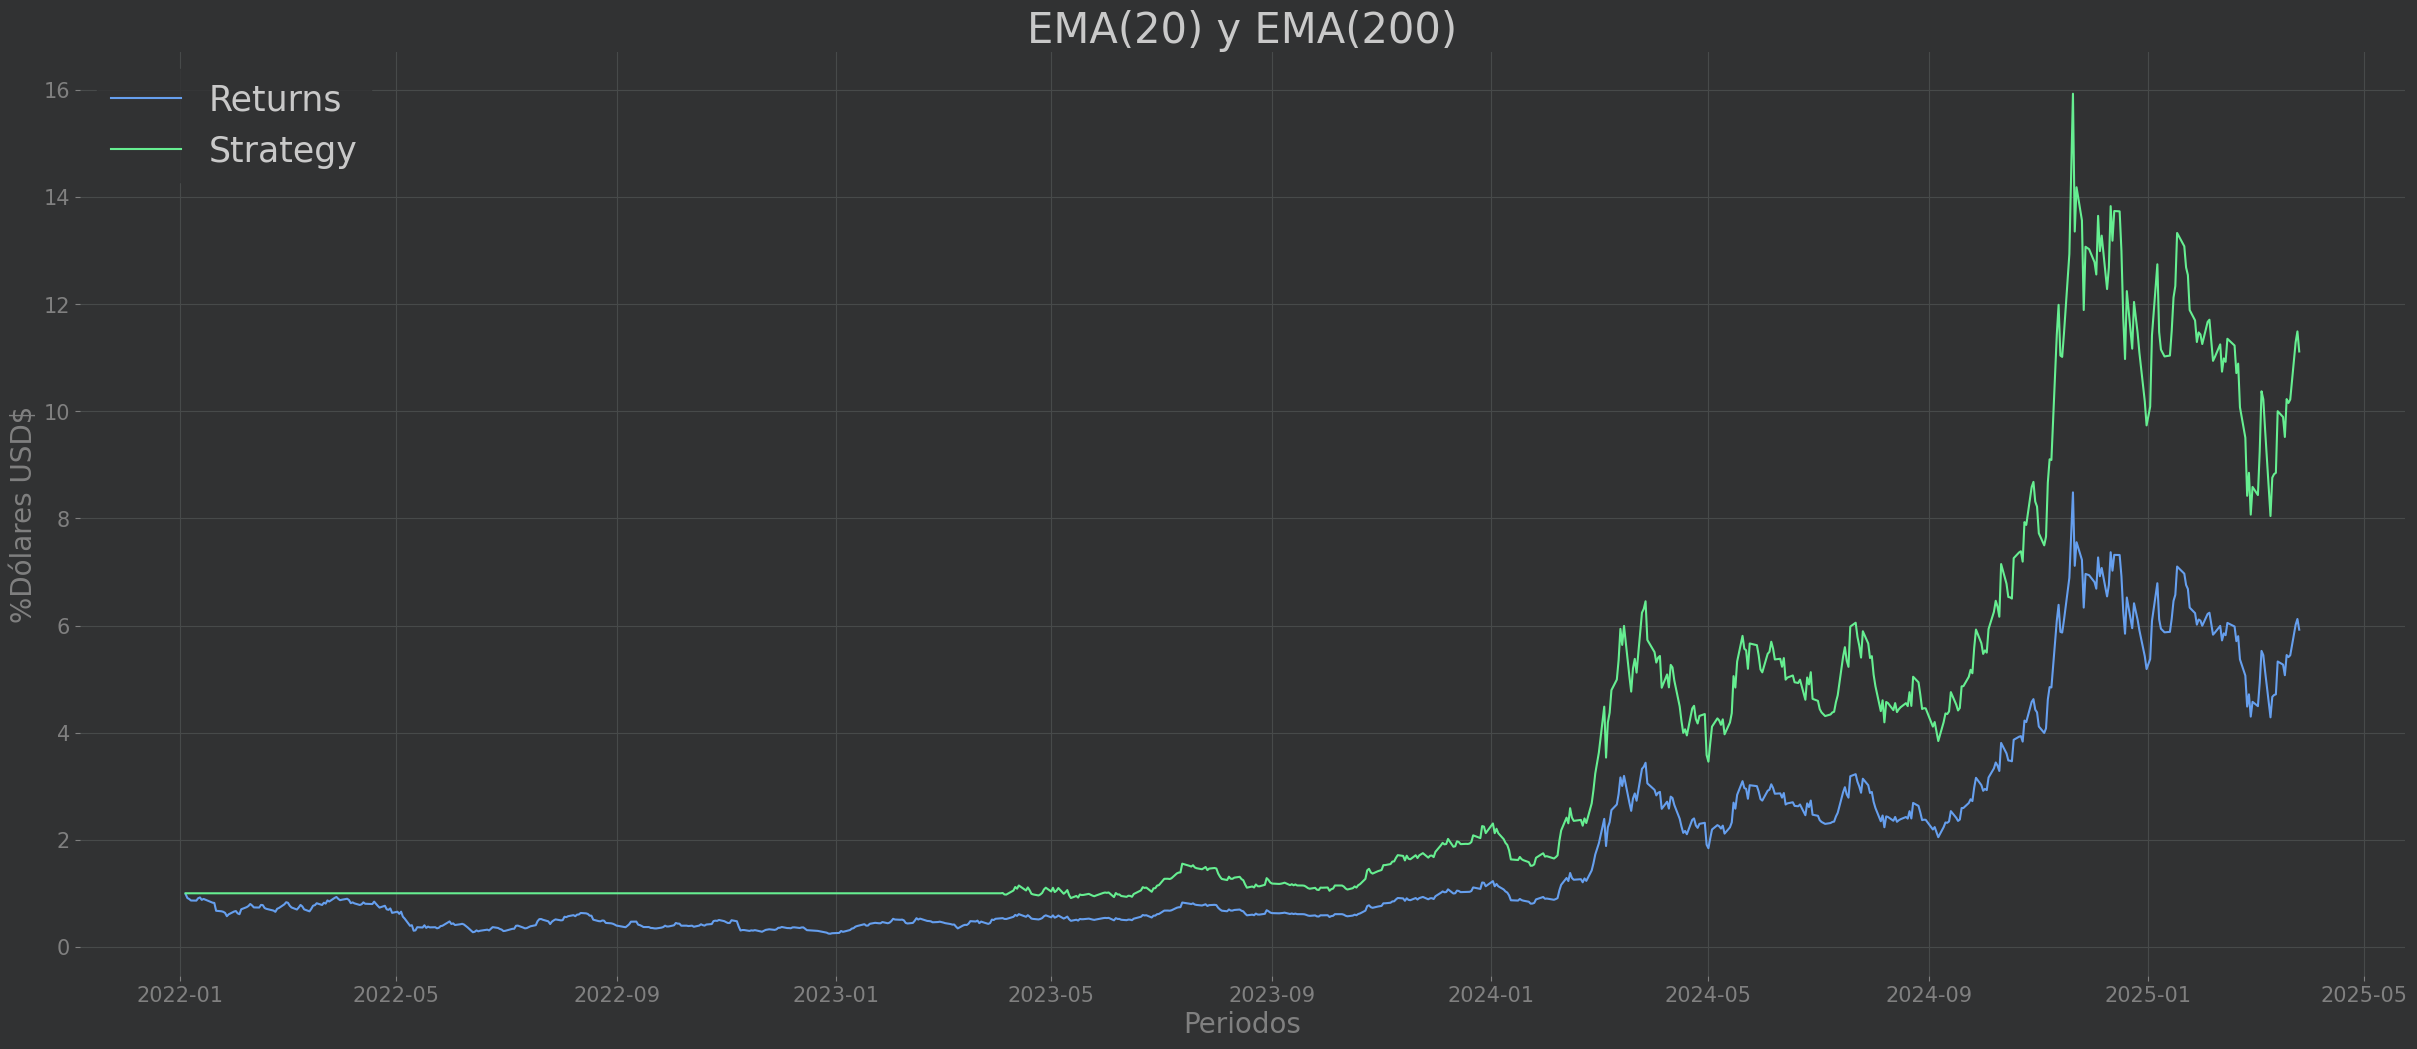

[*********************100%***********************]  1 of 1 completed


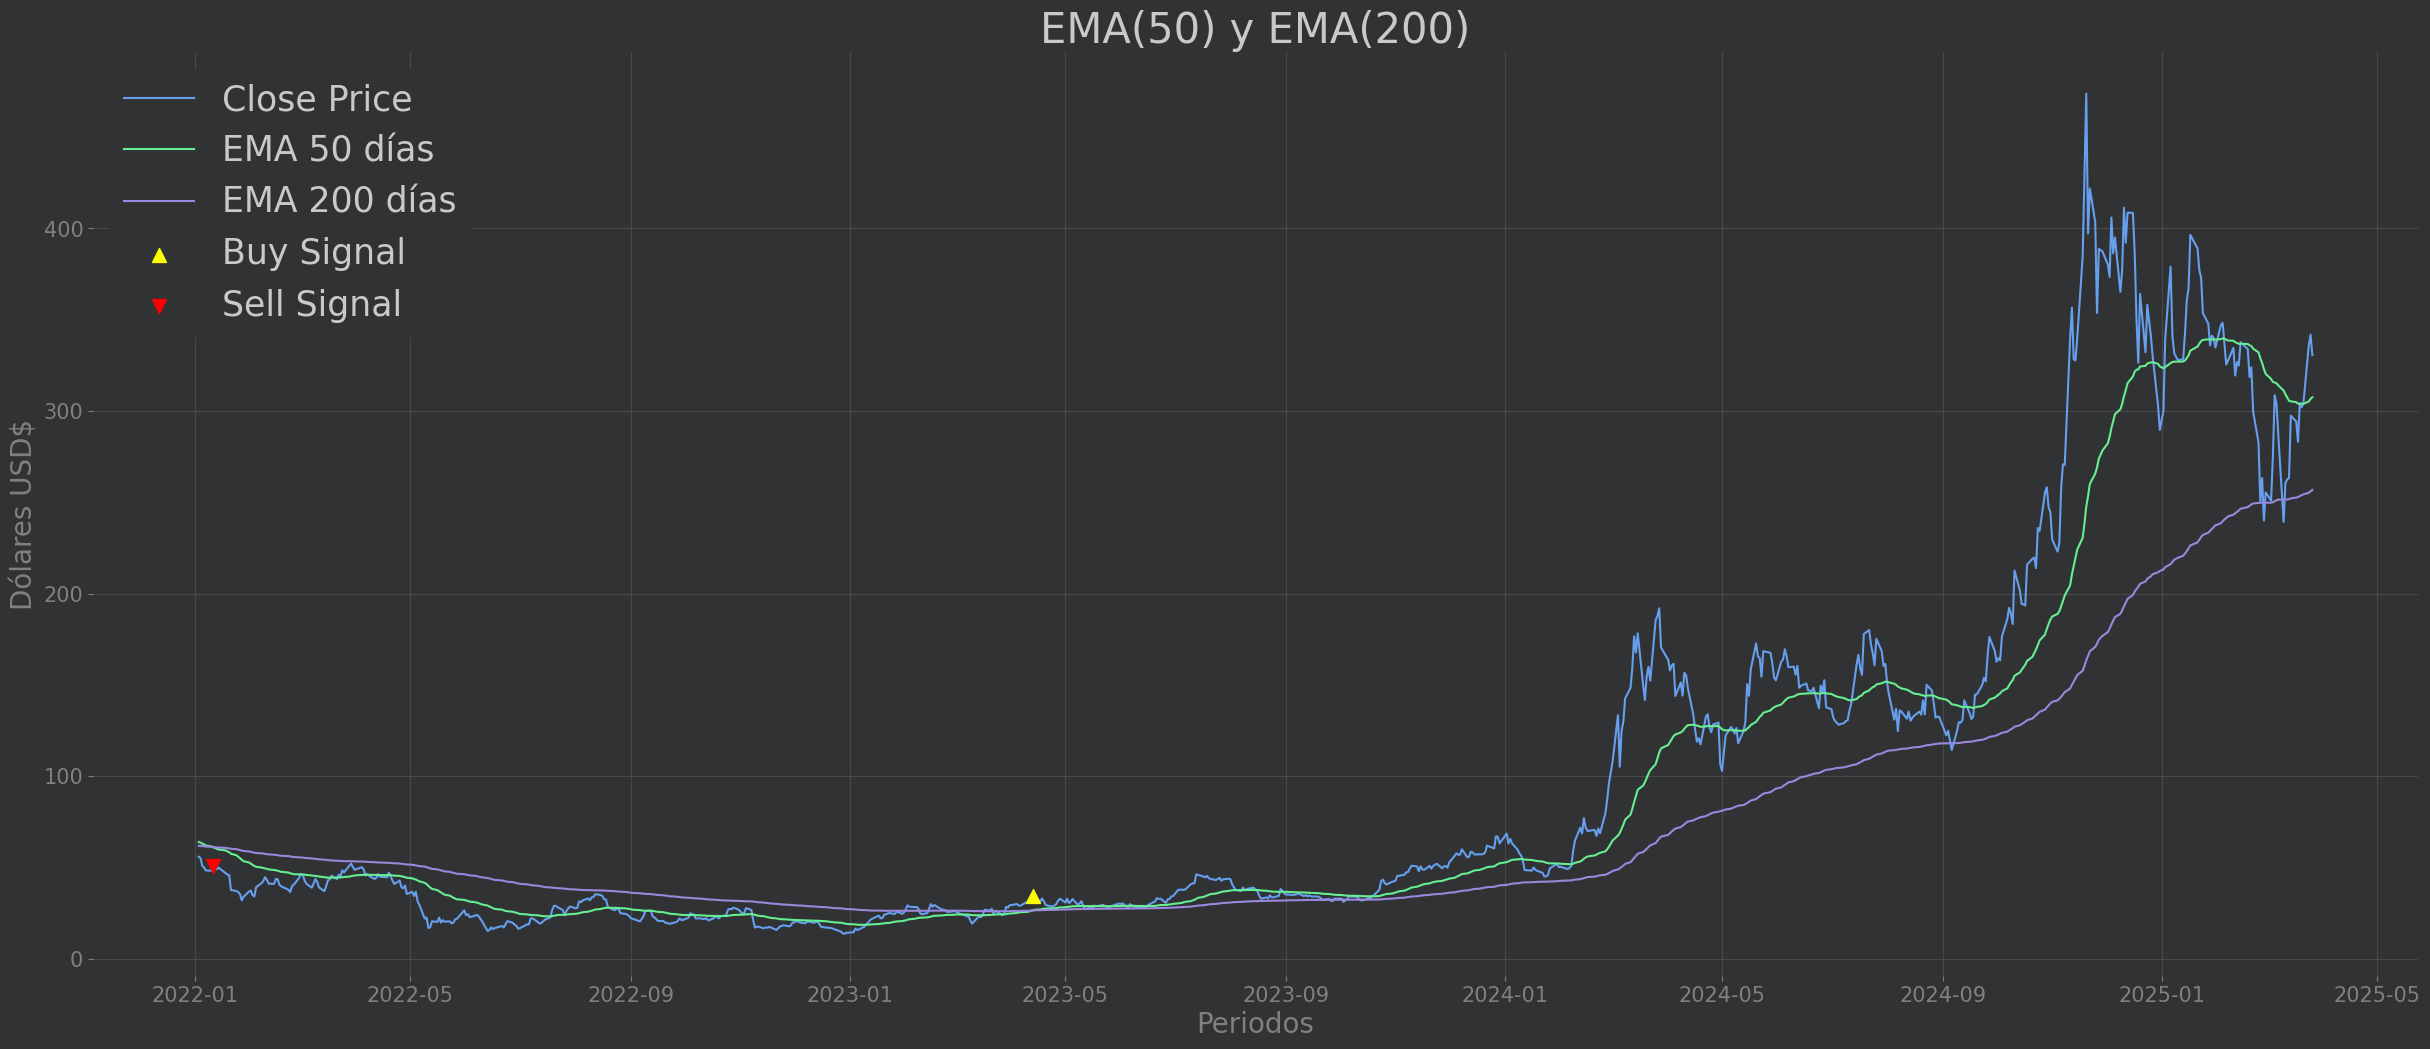

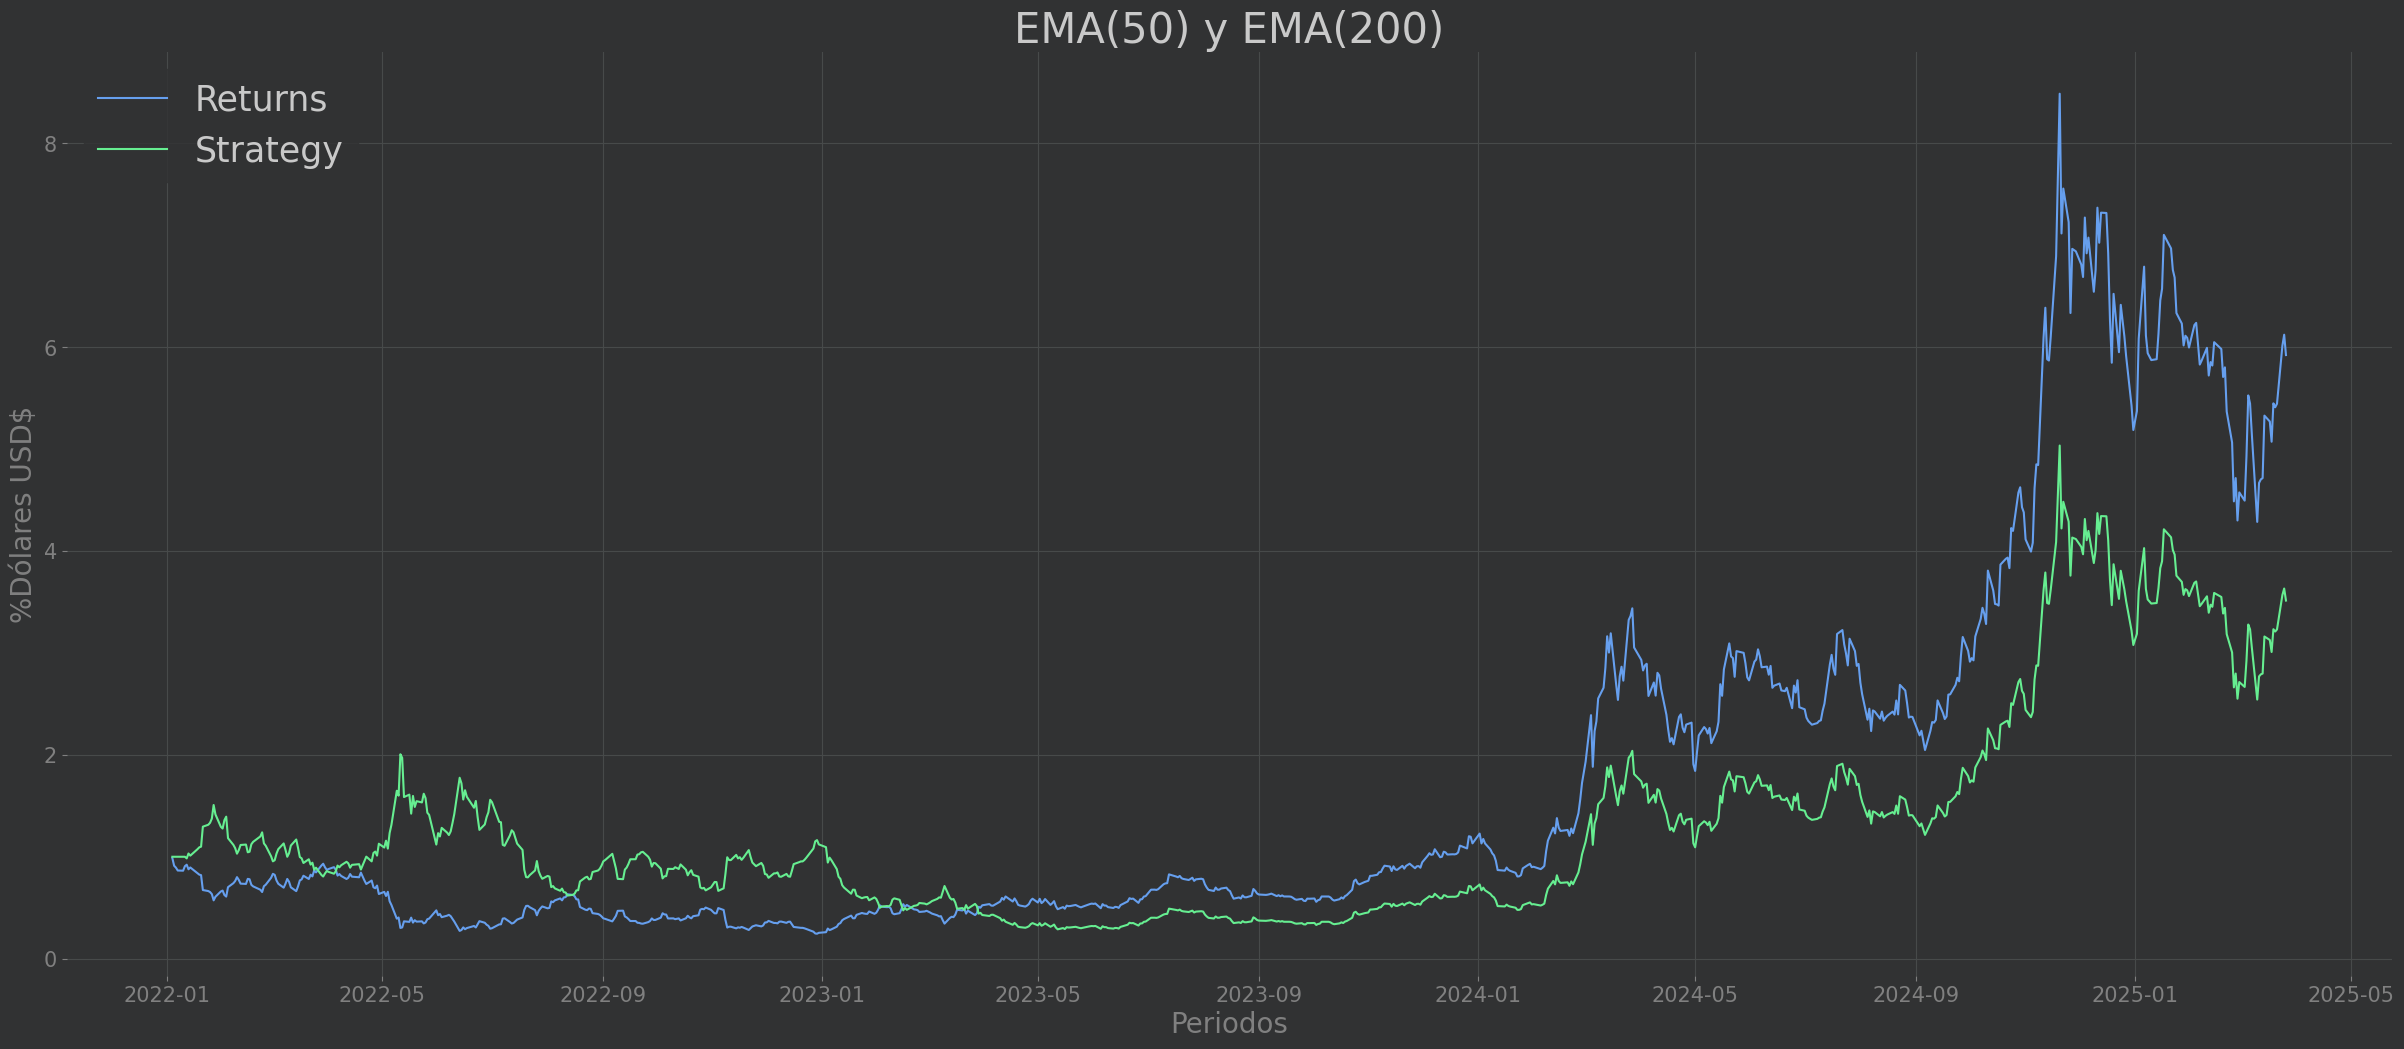

In [3]:
data = pd.DataFrame()

Strat_comb = [(12, 26), (10, 50), (20, 200), (50, 200)]
flag = True
for strat in ["SMA", "EMA"]:
    for comb in Strat_comb:
        temp = MA_strat("MSTR", comb[0], comb[1], strat)
        if flag:
            data["cpct"] = temp["cpct"].copy()
            flag = False
        data[f'{strat} {comb}'] = temp["creturns"].copy()

In [4]:
data

,cpct,"SMA (12, 26)","SMA (10, 50)","SMA (20, 200)","SMA (50, 200)","EMA (12, 26)","EMA (10, 50)","EMA (20, 200)","EMA (50, 200)"
Date,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.987121,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-01-05,0.911941,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-01-06,0.893168,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-01-07,0.865099,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
2025-03-20,5.410920,0.693244,0.032170,10.607881,6.138569,0.208871,0.047596,10.157369,3.210041
2025-03-21,5.445491,0.688815,0.031965,10.675657,6.177789,0.207537,0.047292,10.222267,3.230550
2025-03-24,6.013685,0.616943,0.028629,11.789577,6.822393,0.185882,0.042358,11.288880,3.567633


In [14]:
# Get the last row of the data
last_row = data.iloc[-1]

# Calculate the difference between the last value of each column and the value in 'cpct'
differences = (last_row - last_row['cpct']).round(3).astype(str) + '\%'


# Create a table with the differences and sort it from highest to lowest
result_table = differences.sort_values(ascending=False).to_frame(name='Difference \%')

print(result_table.to_latex(index=True))

\begin{tabular}{ll}
\toprule
 & Difference \% \\
\midrule
SMA (20, 200) & 5.689\% \\
EMA (20, 200) & 5.196\% \\
SMA (50, 200) & 0.797\% \\
cpct & 0.0\% \\
SMA (10, 50) & -5.894\% \\
EMA (10, 50) & -5.88\% \\
EMA (12, 26) & -5.747\% \\
SMA (12, 26) & -5.337\% \\
EMA (50, 200) & -2.409\% \\
\bottomrule
\end{tabular}

